In [2]:
import uproot
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as opt
import sys
import h5py
import os
from sklearn import metrics

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

/tmp/ipykernel_58200/2284580335.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [4]:
#sys.path.append('/home/nprouse/WatChMaL/WatChMaL')
sys.path.append('/home/lbidulka')
import WatChMaL.analysis.event_utils as ev
from WatChMaL.analysis.multi_plot_utils import multi_disp_learn_hist, multi_compute_roc, multi_plot_roc
from WatChMaL.analysis.comparison_utils import multi_get_masked_data, multi_collapse_test_output
from WatChMaL.analysis.plot_utils import disp_learn_hist_smoothed, plot_confusion_matrix

In [5]:
# list of particle names to use in filename
particle_names = ['gamma', 'e-', 'mu-', 'pi0'] # note that the order corresponds to labels 0, 1, 2, 3

# Save Plots?

In [6]:
SAVE_PLOTS = True

# Preparing data

## Get true particle data from h5 file

In [8]:
# get indices of test events
idxs_path = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short/index_lists/4class_e_mu_gamma_pi0/IWCD_mPMT_Short_4_class_3M_emgp0_idxs.npz'
idxs = np.load(idxs_path, allow_pickle=True)
test_idxs  = idxs['test_idxs']


### Open H5 data

In [9]:
# open h5 file and get data for test events
data_path = "/fast_scratch/WatChMaL/data/IWCD_mPMT_Short/IWCD_mPMT_Short_emgp0_E0to1000MeV_digihits.h5"
h5_file = h5py.File(data_path, "r")
h5_angles     = np.array(h5_file['angles'])[test_idxs].squeeze()
h5_energies   = np.array(h5_file['energies'])[test_idxs].squeeze()
h5_positions  = np.array(h5_file['positions'])[test_idxs].squeeze()
h5_labels     = np.array(h5_file['labels'])[test_idxs].squeeze()
h5_root_files = np.array(h5_file['root_files'])[test_idxs].squeeze()
h5_event_ids  = np.array(h5_file['event_ids'])[test_idxs].squeeze()
h5_vetos      = np.array(h5_file['veto'])[test_idxs].squeeze()

## Get fiTQun data from files

In [10]:
# create dictionaries to fill with fitqun data for each particle type
flag_e = {}
flag_mu = {}
flag_pi0 = {}
e_nll = {}
mu_nll = {}
pi0_nll = {}
reco_mom_e = {}
reco_mom_mu = {}
reco_mom_pi0 = {}
reco_pos_e = {}
reco_dir_e = {}
pi0mass = {}
particles = {}
totq = {}

In [11]:
# get the data from the fitqun files
fq_path = "/fast_scratch/WatChMaL/data/IWCD_mPMT_Short/fiTQun/"
for p in particle_names:
    # open the fiTQun TTree from the file with uproot
    fq = uproot.open(fq_path+f"IWCD_mPMT_Short_{p}_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root")['fiTQun']
    # extract each branch of the TTree fom the ROOT file into a numpy array, placed in the dictionaries
    flag_e[p] = np.array(fq['fq1rpcflg'].array()[:,0,1])
    flag_mu[p] = np.array(fq['fq1rpcflg'].array()[:,0,2])
    flag_pi0[p] = np.array(fq['fqpi0pcflg'].array()[:,0])
    e_nll[p] = np.array(fq['fq1rnll'].array()[:,0,1])
    mu_nll[p] = np.array(fq['fq1rnll'].array()[:,0,2])
    pi0_nll[p] = np.array(fq['fqpi0nll'].array()[:,0])
    reco_mom_e[p] = np.array(fq['fq1rmom'].array()[:,0,1])
    reco_mom_mu[p] = np.array(fq['fq1rmom'].array()[:,0,2])
    reco_mom_pi0[p] = np.array(fq['fqpi0momtot'].array()[:,0])
    reco_pos_e[p] = np.array(fq['fq1rpos'].array()[:,0,1,:])
    reco_dir_e[p] = np.array(fq['fq1rdir'].array()[:,0,1,:])
    pi0mass[p] = np.array(fq['fqpi0mass'].array()[:,0])
    totq[p] = np.array(fq['fqtotq'].array()[:,0])
    # the labels are just 0, 1, 2, or 3 based on which particle it is, repeated for the number of events
    particles[p] = np.repeat(particle_names.index(p), fq.num_entries)

In [12]:
# create arrays stacking together the particles
# the order of the particles in the test set of the h5 file is [e-, mu-, gamma, pi0]
particle_order = [particle_names[i] for i in h5_labels[::1200000]] #['e-', 'mu-', 'gamma', 'pi0']
fq_flag_e = np.concatenate([flag_e[i] for i in particle_order])
fq_flag_mu = np.concatenate([flag_mu[i] for i in particle_order])
fq_flag_pi0 = np.concatenate([flag_pi0[i] for i in particle_order])
fq_e_nll = np.concatenate([e_nll[i] for i in particle_order])
fq_mu_nll = np.concatenate([mu_nll[i] for i in particle_order])
fq_pi0_nll = np.concatenate([pi0_nll[i] for i in particle_order])
fq_reco_mom_e = np.concatenate([reco_mom_e[i] for i in particle_order])
fq_reco_mom_mu = np.concatenate([reco_mom_mu[i] for i in particle_order])
fq_reco_mom_pi0 = np.concatenate([reco_mom_pi0[i] for i in particle_order])
fq_reco_pos_e = np.concatenate([reco_pos_e[i] for i in particle_order])
fq_reco_dir_e = np.concatenate([reco_dir_e[i] for i in particle_order])
fq_pi0mass = np.concatenate([pi0mass[i] for i in particle_order])
fq_particles = np.concatenate([particles[i] for i in particle_order])
fq_totq = np.concatenate([totq[i] for i in particle_order])

## Find the fiTQun events corresponding to the test set
For the IWCD mPMT e/mu/gamma/pi0 data, there are events missing from the h5 digihits file (used for training and testing) that are not missing from the fiTQun set, so we need to find how to match them up properly. We use the following to match them up:
- Each event in the h5 file has a `label` (particle type), a `root_file` and a `event_id`
- The events in the h5 file are ordered by `label` then `root_file` then `event_id`
- The fiTQun files have all events for one particle type, ordered by `root_file`, then by `event_id`
- Each `root_file` originally has exactly 3000 events in the fiTQun file
- The `event_id`s in for each root file in the fiTQun file go consecutively from 0 to 2999
- The h5 file has a subset of the events in the fiTQun files, and has at least one event from every `root_file`

So we loop through the h5 file events, check the `label` to find which particle it is to choose the corresponding fitqun file, check the `root_file`, if it's the same as the previous then we compare to previous `event_id` and if there's a jump then we skip [new `event_id` minus old `event_id`+1] events in the fiTQun files. If it's a new `root_file` then we skip [new `event_id` plus 3000 minus old `event_id`+1].

Or, we do it more efficiently by adding up offsets by particle type, root file and event_id, because we know:
- There are 400 `root_files` included in the test set for each particle
- There are 3000 `event_id`s running from 0 to 2999 for each `root_file`
So, if we index the `root_files` from 0 to 399 for particle 0, 400 to 799 for particle 1, and so on, then the offset is just `3000*[root_file_index] + [event_id]`

In [13]:
# create dictionary with keys of the unique root_files
root_file_index = dict.fromkeys(h5_root_files)
# update the values to be ascending order
root_file_index.update((k, i) for i, k in enumerate(root_file_index))

In [14]:
root_file_indices = np.vectorize(root_file_index.__getitem__)(h5_root_files)
h5_fq_offsets = 3000*root_file_indices + h5_event_ids


In [15]:
h5_flag_e = fq_flag_e[h5_fq_offsets]
h5_flag_mu = fq_flag_mu[h5_fq_offsets]
h5_flag_pi0 = fq_flag_pi0[h5_fq_offsets]
h5_e_nll = fq_e_nll[h5_fq_offsets]
h5_mu_nll = fq_mu_nll[h5_fq_offsets]
h5_pi0_nll = fq_pi0_nll[h5_fq_offsets]
h5_reco_mom_e = fq_reco_mom_e[h5_fq_offsets]
h5_reco_mom_mu = fq_reco_mom_mu[h5_fq_offsets]
h5_reco_mom_pi0 = fq_reco_mom_pi0[h5_fq_offsets]
h5_reco_pos_e = fq_reco_pos_e[h5_fq_offsets]
h5_reco_dir_e = fq_reco_dir_e[h5_fq_offsets]
h5_pi0mass = fq_pi0mass[h5_fq_offsets]
h5_particles = fq_particles[h5_fq_offsets]
h5_totq = fq_totq[h5_fq_offsets]

# Plotting fiTQun and ResNet performance

## Load ResNet results

In [16]:
#          '/home/mittal41/WatChMaL/outputs/2021-09-28/13-12-37/outputs',              # 4-class/front-back
#          '/home/mittal41/WatChMaL/outputs/2021-09-28/13-15-23/outputs',              # 4-class/180
#          '/home/mittal41/WatChMaL/outputs/2021-10-06/20-19-56/outputs',              # 4-class/front-back repeat
#          '/home/mittal41/WatChMaL/outputs/2021-10-06/20-21-24/outputs',              # 4-class/180 repeat
#          '/home/mittal41/WatChMaL/outputs/2021-10-18/14-29-39/outputs',              # 4-class/No Augmentations
#          '/home/mittal41/WatChMaL/outputs/2021-10-18/14-30-15/outputs'               # 4-class/No Augmentations
#          '/home/mittal41/WatChMaL/outputs/2021-11-01/10-59-09/outputs'
#          '/home/mittal41/WatChMaL/outputs/2021-11-01/23-04-37/outputs'               # Re-evaluate 
#          '/home/nprouse/WatChMaL/WatChMaL/outputs/2021-11-03/15-29-51/outputs',      # nick test
#          '/home/mittal41/WatChMaL/outputs/2021-11-03/16-24-34/outputs',              # Batch Size 4096
#          '/home/mittal41/WatChMaL/outputs/2021-11-03/16-26-01/outputs',              # Double Cover
#          '/home/mittal41/WatChMaL/outputs/2021-11-05/03-32-17/outputs',              # Last Epoch Model 
#          '/home/mittal41/WatChMaL/outputs/2021-11-04/19-17-36/outputs',              # Best Validation Model
#          '/home/mittal41/WatChMaL/outputs/2021-11-05/12-22-54/outputs',              # 19th epoch
#          '/home/mittal41/WatChMaL/outputs/2021-11-06/16-50-56/outputs',              # Batch Size 8192 
#          '/home/mittal41/WatChMaL/outputs/2021-11-08/02-10-25/outputs'               # Batch Size 8192, lr=0.001 (Best model yet)
#          '/home/mittal41/WatChMaL/outputs/2021-11-10/19-55-51/outputs'               # Batch Size 8192, lr=0.001, Vertically flipped
#          '/home/mittal41/WatChMaL/outputs/2021-11-10/23-42-44/outputs'               # Batch Size 8192, lr=0.001, Eval Vertically flipped
#          '/home/mittal41/WatChMaL/outputs/2021-11-11/00-03-11/outputs'               # Batch Size 8192, lr=0.001, Eval Vertically flipped
#          '/home/nprouse/WatChMaL/WatChMaL/outputs/2021-11-11/23-46-25/outputs',       # tbs 8192, vbs 16384, lr=0.001
#          '/home/nprouse/WatChMaL/WatChMaL/outputs/2021-11-12/01-25-02/outputs',       # tbs 8192, vbs 16384, lr=0.001
#          '/home/nprouse/WatChMaL/WatChMaL/outputs/2021-11-12/01-49-59/outputs',       # tbs 8192, vbs 16384, lr=0.001
#          '/home/nprouse/WatChMaL/WatChMaL/outputs/2021-11-12/02-56-13/outputs',       # tbs 8192, vbs 16384, lr=0.001
#          '/home/nprouse/WatChMaL/WatChMaL/outputs/2021-11-12/02-59-13/outputs',       # tbs 8192, vbs 16384, lr=0.001, flipped
#          '/home/nprouse/WatChMaL/WatChMaL/outputs/2021-11-12/03-03-10/outputs',       # tbs 8192, vbs 16384, lr=0.001, flipped
#          '/home/nprouse/WatChMaL/WatChMaL/outputs/2021-11-12/03-09-47/outputs',       # tbs 8192, vbs 16384, lr=0.001, flipped
#          '/home/nprouse/WatChMaL/WatChMaL/outputs/2021-11-12/03-27-46/outputs',       # tbs 8192, vbs 16384, lr=0.001, flipped


#          '/data/WatChMaL/outputs/2021-11-16/01-53-03/outputs'                        # tbs 8192, vbs 16384, SGD, lambda=0.01
#          '/data/WatChMaL/outputs/2021-11-16/02-14-02/outputs'                        # tbs 8192, vbs 16384, SGD, lambda=0.01
#          '/data/WatChMaL/outputs/2021-11-16/02-14-54/outputs'                        # tbs 8192, vbs 16384, SGD, lambda=0.01
#          '/data/WatChMaL/outputs/2021-11-16/02-23-39/outputs'                        # tbs 8192, vbs 16384, SGD, lambda=0.01


#          '/home/mittal41/WatChMaL/outputs/2021-11-17/04-34-06/outputs'               # tbs 8192, vbs 16384, 50 epochs, lr=0.0001
#          '/home/mittal41/WatChMaL/outputs/2021-11-17/04-34-14/outputs'               # tbs 8192, vbs 16384, 50 epochs, lr=0.0001
#          '/home/mittal41/WatChMaL/outputs/2021-11-17/04-34-31/outputs'               # tbs 8192, vbs 16384, 50 epochs, lr=0.0001
#          '/home/mittal41/WatChMaL/outputs/2021-11-17/04-34-43/outputs'               # tbs 8192, vbs 16384, 50 epochs, lr=0.0001

#          '/home/mittal41/WatChMaL/outputs/2021-11-19/21-27-22/outputs'               # tbs 8192, vbs 16384, 70 epochs, lr=0.0001


#          '/home/mittal41/WatChMaL/outputs/2021-11-22/21-37-25/outputs'               # tbs 8192, vbs 16384, SGD,lr=0.001
#          '/home/mittal41/WatChMaL/outputs/2021-11-22/21-41-33/outputs'               # tbs 8192, vbs 16384, SGD,lr=0.001

#          '/home/mittal41/WatChMaL/outputs/2021-11-23/19-58-58/outputs'               # tbs 8192, vbs 16384, SGD, lr=1
#          '/home/mittal41/WatChMaL/outputs/2021-11-24/18-44-39/outputs'               # tbs 8192, vbs 16384, SGD, lr=1 
#          '/home/mittal41/WatChMaL/outputs/2021-11-24/18-56-46/outputs'               # tbs 8192, vbs 16384, SGD, lr=1
#          '/home/mittal41/WatChMaL/outputs/2021-11-24/18-26-52/outputs'               # tbs 8192, vbs 16384, SGD, lr=1
#          '/home/mittal41/WatChMaL/outputs/2021-11-24/19-20-53/outputs'               # tbs 8192, vbs 16384, SGD, lr=1


#         '/home/mittal41/WatChMaL/outputs/2021-11-26/02-22-09/outputs'                # Validation after training
#         '/home/mittal41/WatChMaL/outputs/2021-11-26/02-51-15/outputs'                # Validation after training
#         '/home/mittal41/WatChMaL/outputs/2021-11-26/03-02-20/outputs'                # Validation after training


#         '/home/mittal41/WatChMaL/outputs/2021-11-30/15-08-59/outputs'                # Default batch sizes
#         '/home/mittal41/WatChMaL/outputs/2021-12-01/06-15-49/outputs'                # 17th epoch
#         '/home/mittal41/WatChMaL/outputs/2021-12-01/06-16-04/outputs'                # 18th epoch
#         '/home/mittal41/WatChMaL/outputs/2021-12-01/06-16-18/outputs'                # 19th epoch
#         '/home/mittal41/WatChMaL/outputs/2021-12-01/06-17-27/outputs'                # 20th epoch

#         '/home/mittal41/WatChMaL/outputs/2021-12-06/17-57-30/outputs'                # Bs1024, no vertical flip
#         '/home/mittal41/WatChMaL/outputs/2021-12-07/12-07-02/outputs'                # 17th epoch
#         '/home/mittal41/WatChMaL/outputs/2021-12-07/12-07-49/outputs'                # 18th epoch
#         '/home/mittal41/WatChMaL/outputs/2021-12-07/12-08-20/outputs'                # 19th epoch
#         '/home/mittal41/WatChMaL/outputs/2021-12-07/12-08-40/outputs'                # 20th epoch

#         '/home/mittal41/WatChMaL/outputs/2021-12-08/04-59-26/outputs'                # tbs 8192, vbs 16384, SGD, Scheduler, gamma=0.93 
#         '/home/mittal41/WatChMaL/outputs/2021-12-08/16-26-23/outputs'                # tbs 8192, vbs 16384, SGD, Scheduler, gamma=0.93 
#         '/home/mittal41/WatChMaL/outputs/2021-12-08/16-27-25/outputs'                # tbs 8192, vbs 16384, SGD, Scheduler, gamma=0.93 
#         '/home/mittal41/WatChMaL/outputs/2021-12-08/18-58-45/outputs'                # tbs 8192, vbs 16384, SGD, Scheduler, gamma=0.93 







In [17]:

short_locs = [ 
#     '/home/mittal41/WatChMaL/outputs/2021-09-28/13-15-23/outputs',
#     '/home/mittal41/WatChMaL/outputs/2021-10-06/20-21-24/outputs',
#     '/home/mittal41/WatChMaL/outputs/2021-11-03/16-26-01/outputs',
#     '/home/mittal41/WatChMaL/outputs/2021-11-08/02-10-25/outputs'
#          '/home/nprouse/WatChMaL/WatChMaL/outputs/2021-11-11/23-46-25/outputs',       # tbs 8192, vbs 16384, lr=0.001
#          '/home/nprouse/WatChMaL/WatChMaL/outputs/2021-11-12/01-25-02/outputs',       # tbs 8192, vbs 16384, lr=0.001
    
#          '/home/mittal41/WatChMaL/outputs/2021-12-08/04-59-26/outputs',                # tbs 8192, vbs 16384, SGD, Scheduler, gamma=0.93 
#          '/home/mittal41/WatChMaL/outputs/2021-12-08/16-26-23/outputs',                # tbs 8192, vbs 16384, SGD, Scheduler, gamma=0.93 
#          '/home/mittal41/WatChMaL/outputs/2021-12-08/16-27-25/outputs',                # tbs 8192, vbs 16384, SGD, Scheduler, gamma=0.93 
#          '/home/mittal41/WatChMaL/outputs/2021-12-08/18-58-45/outputs',                # tbs 8192, vbs 16384, SGD, Scheduler, gamma=0.93 
#          '/home/nprouse/WatChMaL/WatChMaL/outputs/2021-11-12/01-49-59/outputs',       # tbs 8192, vbs 16384, lr=0.001
#          '/home/nprouse/WatChMaL/WatChMaL/outputs/2021-11-12/02-56-13/outputs',       # tbs 8192, vbs 16384, lr=0.001
#          '/home/nprouse/WatChMaL/WatChMaL/outputs/2021-11-12/02-59-13/outputs',       # tbs 8192, vbs 16384, lr=0.001, flipped
#          '/home/nprouse/WatChMaL/WatChMaL/outputs/2021-11-12/03-03-10/outputs',       # tbs 8192, vbs 16384, lr=0.001, flipped
#          '/home/nprouse/WatChMaL/WatChMaL/outputs/2021-11-12/03-09-47/outputs',       # tbs 8192, vbs 16384, lr=0.001, flipped
#          '/home/nprouse/WatChMaL/WatChMaL/outputs/2021-11-12/03-27-46/outputs',       # tbs 8192, vbs 16384, lr=0.001, flipped
    
        #  '/home/mittal41/WatChMaL/outputs/2021-11-08/02-10-25/outputs', # Batch Size 8192, lr=0.001 (Best model yet)
        #  '/home/nprouse/WatChMaL/WatChMaL/outputs/2021-11-11/23-46-25/outputs', # tbs 8192, vbs 16384, lr=0.001
        #'/data/WatChMaL/outputs/2021-11-16/01-53-03/outputs', # tbs 8192, vbs 16384, SGD, lambda=0.01
        #  '/home/mittal41/WatChMaL/outputs/2021-11-17/04-34-06/outputs', # tbs 8192, vbs 16384, 50 epochs, lr=0.0001
        #  '/home/mittal41/WatChMaL/outputs/2021-11-19/21-27-22/outputs', # tbs 8192, vbs 16384, 70 epochs, lr=0.0001
        #'/home/mittal41/WatChMaL/outputs/2021-11-23/19-58-58/outputs', # tbs 8192, vbs 16384, SGD, lr=1
        #  '/home/mittal41/WatChMaL/outputs/2021-11-26/02-22-09/outputs', # Validation after training
        #  '/home/mittal41/WatChMaL/outputs/2021-11-30/15-08-59/outputs', # Default batch sizes (512)
        #'/home/mittal41/WatChMaL/outputs/2021-12-06/17-57-30/outputs', # Bs1024, no vertical flip
        #'/home/mittal41/WatChMaL/outputs/2021-12-08/18-58-45/outputs', # tbs 8192, vbs 16384, SGD, Scheduler, gamma=0.93
    
        #'/home/lbidulka/WatChMaL/outputs/2022-06-13/09-25-53/outputs',    # tbs 4096, vbs 4096, lr=0.001, extra gamma/elec data
        #'/home/lbidulka/WatChMaL/outputs/2022-06-14/11-45-33/outputs',    # tbs 4096, vbs 4096, lr=0.001, extra gamma/elec data
        #'/home/lbidulka/WatChMaL/outputs/2022-06-16/09-08-52/outputs',    # tbs 4096, vbs 4096, lr=0.001, extra gamma/elec data
        #'/home/lbidulka/WatChMaL/outputs/2022-06-17/09-42-58/outputs',    # bs4096, lr0.001
        #'/home/lbidulka/WatChMaL/outputs/2022-06-20/12-03-34/outputs',    # 4cl, bs1024, lr0.001
        #'/home/lbidulka/WatChMaL/outputs/2022-06-23/09-37-02/outputs',    # 4cl, official resnet bs4096, lr0.001
    
        '/home/lbidulka/WatChMaL/outputs/2022-06-28/09-06-55/outputs',    # 4cl, resnet-official conv1(19-64,1x1), bs1024
#         '/home/lbidulka/WatChMaL/outputs/2022-07-20/08-50-51/outputs',    # 4cl, resnet-official conv1(19-64,1x1), bs1024
#         '/home/lbidulka/WatChMaL/outputs/2022-07-21/08-13-36/outputs',    # 4cl, resnet-official conv1(19-64,1x1), bs1024
#         '/home/lbidulka/WatChMaL/outputs/2022-07-22/12-23-57/outputs',    # 4cl, resnet-official conv1(19-64,1x1), bs1024
]

legend = [
#     'mpmtPadding',
#     'mpmtPadding',
#     'Double Cover',
#     'Double Cover'
#    f"Adam, tbs 8192, vbs 16384, lr=0.001 {i}" for i in range(1,3)
]

#  legend.append("Batch Size 8192, lr=0.001 (Best model yet)")
#  legend.append("tbs 8192, vbs 16384, lr=0.001")
#legend.append("tbs 8192, vbs 16384, SGD, lambda=0.01")
#  legend.append("tbs 8192, vbs 16384, 50 epochs, lr=0.0001")
#  legend.append("tbs 8192, vbs 16384, 70 epochs, lr=0.0001")
#legend.append("tbs 8192, vbs 16384, SGD, lr=1")
#  legend.append("Validation after training")
#  legend.append("Default batch sizes")
#legend.append("Bs1024, no vertical flip")
#legend.append("tbs 8192, vbs 16384, SGD, Scheduler, gamma=0.93")

#legend.append("bs4096, lr0.001")
#legend.append("bs1024, lr0.001")
#legend.append("official resnet, bs4096, lr0.001")

legend.append("ResNet")

# legend.append("official resnet, conv1(19-64,1x1), bs1024, lr0.001")
# legend.append("official resnet, conv1(19-64,1x1), bs1024, lr0.001, rerun 1")
# legend.append("official resnet, conv1(19-64,1x1), bs1024, lr0.001, rerun 2")
# legend.append("official resnet, conv1(19-64,1x1), bs1024, lr0.001, rerun 3")

# colors = ["#ff0000", "#f032e6", "#3cb44b", "#ff0000", "#f032e6", "#000075","#000075","#808080"]

colors = [
#     'red',
#     'red',
#     'blue',
#     'blue',
    'tab:orange',
    'tab:blue',
    #'tab:green',
    'tab:red',
    'tab:purple',
    #'tab:brown',
    'tab:pink',
    #'tab:gray', 
    #'tab:olive',
    'tab:cyan',
    
    'yellow',
    'black',
    'lime'
]
print(legend)

['ResNet']


In [18]:
# Using the newer version of the WatChMaL code, we need to match up the events correctly
# in the older version, it always matched up because we always used the same events.
# Set is_new to true for all training runs except when using old results (before Nov.2021).

is_new = [True,True,True,True,True, True, True, True, True]#, True, True, True, True]
#is_new = [False,False,True,True]

In [19]:
n_classes = 4
softmaxes = [np.zeros((test_idxs.shape[0],n_classes)) for loc in short_locs]
indices = [np.load(f'{loc}/indices.npy') for loc in short_locs]
N = len(short_locs)
for i in range(N):
    if is_new[i]:
        # match up indices from output to indices in test_idxs
        intersection = np.intersect1d(indices[i], test_idxs, return_indices=True)
        softmaxes[i][intersection[2]] = np.load(f'{short_locs[i]}/softmax.npy')[intersection[1]]
    else:
        softmaxes[i][indices[i]] = np.load(f'{short_locs[i]}/softmax.npy')

## Set up plotting style

In [20]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

## Make some cuts to select the events of interest

In [21]:
towall = ev.towall(h5_positions, h5_angles)
dwall = ev.dwall(h5_positions)
momentum = ev.momentum(h5_energies, h5_labels)

towall_cut = towall > 0.63*np.log(momentum) # only for electrons
dwall_cut = dwall > 0.5
reco_cut = (h5_flag_e == 0) & (h5_flag_mu == 0)
od_veto_cut = (h5_vetos == 0)

# select the true gamma events that pass the cuts
gammas = (h5_labels==0) & towall_cut & dwall_cut & reco_cut & od_veto_cut

# select the true electron events that pass the cuts
electrons = (h5_labels==1) & towall_cut & dwall_cut & reco_cut & od_veto_cut

# select the true muon events that pass the cuts
muons = (h5_labels==2)  & towall_cut & dwall_cut & reco_cut & od_veto_cut

# select the true muon events that pass the cuts
pi0s = (h5_labels==3)  & towall_cut & dwall_cut & reco_cut & od_veto_cut

# all events passing cuts
emu_cut = electrons | muons
mue_cut = emu_cut
epi0_cut = electrons | pi0s
eg_cut = electrons | gammas
ge_cut = eg_cut

In [22]:
print("gamma pre cut: ", np.count_nonzero(h5_labels == 0))
print("gamma post cut: ", np.count_nonzero(gammas == 1))

print("\nelectron pre cut: ", np.count_nonzero(h5_labels == 1))
print("electron post cut: ", np.count_nonzero(electrons == 1))

print("\nmuon pre cut: ", np.count_nonzero(h5_labels == 2))
print("muon post cut: ", np.count_nonzero(muons == 1))

print("\npi0 pre cut: ", np.count_nonzero(h5_labels == 3))
print("pi0 post cut: ", np.count_nonzero(pi0s == 1))

gamma pre cut:  1182377
gamma post cut:  828097

electron pre cut:  1177966
electron post cut:  815562

muon pre cut:  1164139
muon post cut:  626842

pi0 pre cut:  1147038
pi0 post cut:  758880


## Electron vs Muon

### ROC curve

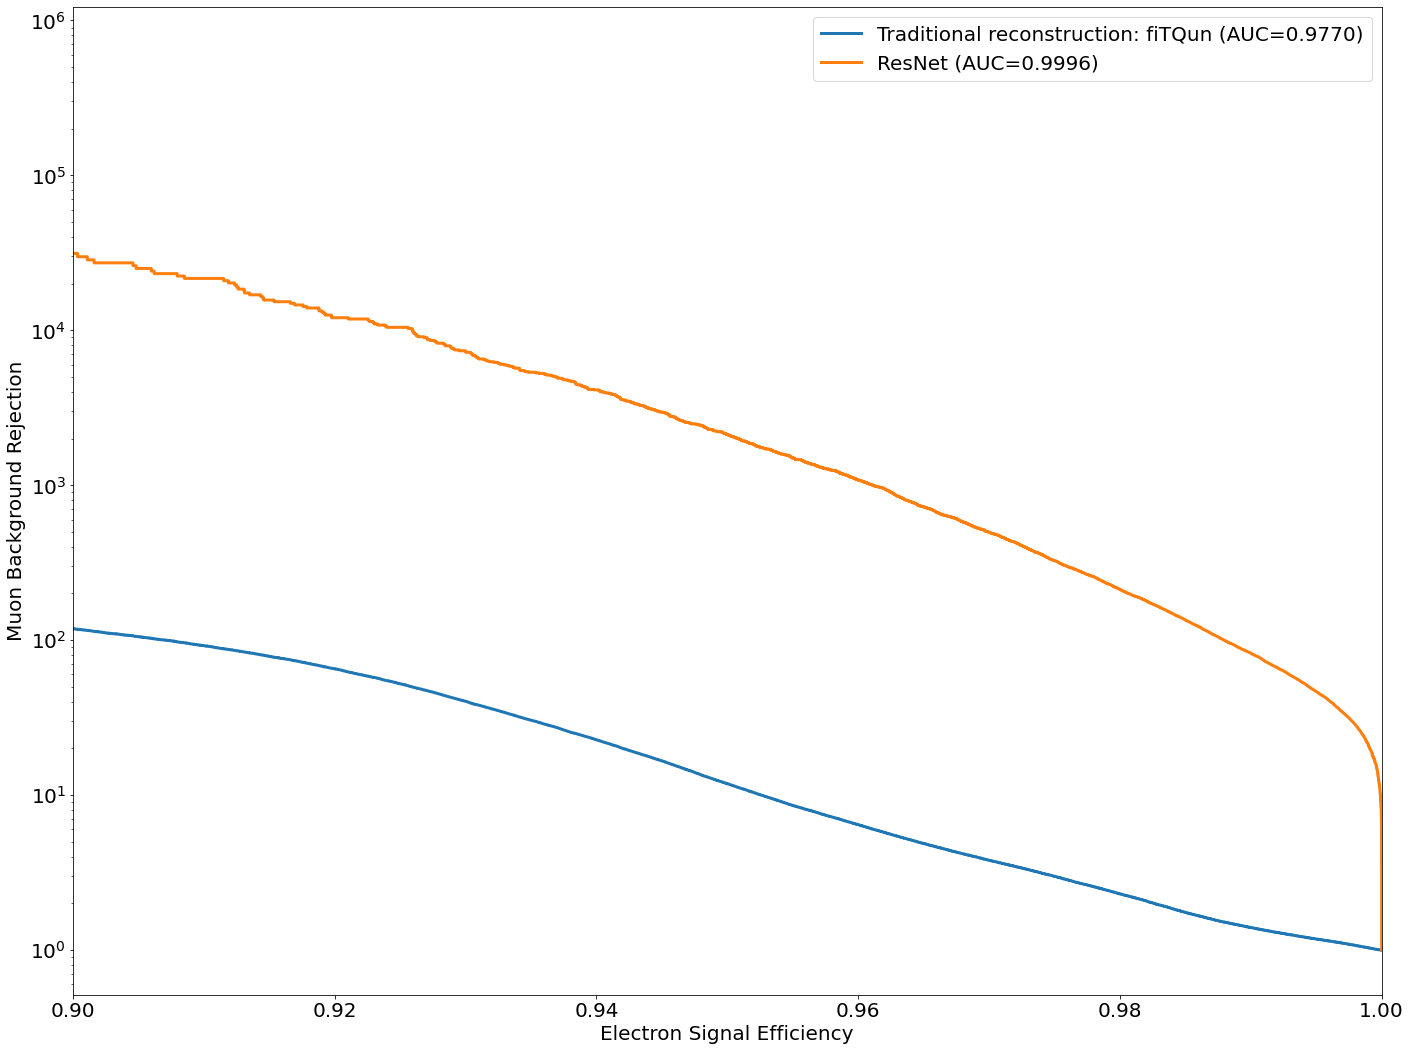

In [23]:
# the electron-like discriminator is the negative log-likelihood difference for fiTQun
mue_nll = h5_mu_nll-h5_e_nll
# the electron-like discriminator is 1-[muon softmax] for ResNet
mue_elike = [1-softmaxes[i][:,2] for i in range(N)]

mue_rn_roc_fpr, mue_rn_roc_tpr = [],[]

# get the true and false positives
mue_fq_roc_fpr, mue_fq_roc_tpr, _ = metrics.roc_curve(h5_labels[mue_cut]==1, mue_nll[mue_cut])  # fitQun
for i in range(N):                                                                              # Resnet
    fpr, tpr, _ = metrics.roc_curve(h5_labels[mue_cut]==1, mue_elike[i][mue_cut])
    mue_rn_roc_fpr.append(fpr)
    mue_rn_roc_tpr.append(tpr)
    
# get the AUC
mue_fq_auc = metrics.auc(mue_fq_roc_fpr, mue_fq_roc_tpr)
mue_rn_auc = [metrics.auc(fpr,tpr) for fpr,tpr in zip(mue_rn_roc_fpr, mue_rn_roc_tpr)]


with np.errstate(divide='ignore'):
    mue_fq_bgr = 1/mue_fq_roc_fpr
    mue_rn_bgr = [1/fpr for fpr in mue_rn_roc_fpr]

# plot the results
fig, ax = plt.subplots(figsize=(20,15))
ax.plot(mue_fq_roc_tpr, mue_fq_bgr, label=f"Traditional reconstruction: fiTQun (AUC={mue_fq_auc:.4f})", lw = 3)

for i in range(N):
    ax.plot(mue_rn_roc_tpr[i], mue_rn_bgr[i], label=f"{legend[i]} (AUC={mue_rn_auc[i]:.4f})", color = colors[i], lw = 3)

ax.set_xlabel("Electron Signal Efficiency")
ax.set_ylabel("Muon Background Rejection")
ax.set_yscale('log')
ax.set_xlim((0.9,1))
ax.legend()
fig.tight_layout()

if SAVE_PLOTS:
    plt.savefig('4_class_results/e_vs_muon/roc.jpg',bbox_inches='tight', dpi=150)

### For fixed 0.5% muon mis-ID

### For each 50 MeV bin of reconstructed momentum, calculate the thresholds for fiTQun

In [24]:
# the electron-like discriminator is the negative log-likelihood difference
emu_nll = h5_mu_nll-h5_e_nll

# set up the bins
emu_bin_low = 0
emu_bin_high = 1000
emu_bin_width = 50
emu_bin_lows = np.arange(emu_bin_low, emu_bin_high, emu_bin_width)

# for each particle type, for each bin, make a boolean array to say whether each event belongs in that bin
emu_e_bin_selections = [
    (h5_reco_mom_e[electrons] > l) & (h5_reco_mom_e[electrons] <= l+emu_bin_width)
    for l in emu_bin_lows
]
emu_mu_bin_selections = [
    (h5_reco_mom_e[muons] > l) & (h5_reco_mom_e[muons] <= l+emu_bin_width)
    for l in emu_bin_lows
]

# for each bin, the threshold that gives 0.1% mis-ID (99.9% are below the threshold)
emu_fq_thresholds = [np.quantile(emu_nll[muons][c], 0.999) for c in emu_mu_bin_selections]

# for each particle type, for each bin, make a, boolean array to say whether each event is below the threshold
# start by filling it full of false
emu_fq_electron_truepositives = np.zeros_like(emu_nll[electrons]).astype(bool)
emu_fq_muon_falsepositives = np.zeros_like(emu_nll[muons]).astype(bool)
# then loop over the bins and set to true for the events in those bins that are over the threshold
for t, c in zip(emu_fq_thresholds, emu_e_bin_selections):
    emu_fq_electron_truepositives[c] = emu_nll[electrons][c] > t
for t, c in zip(emu_fq_thresholds, emu_mu_bin_selections):
    emu_fq_muon_falsepositives[c] = emu_nll[muons][c] > t

### Calculate the thresholds for ResNet

In [25]:
# the electron-like discriminator is 1-[muon softmax] 
emu_elike = [1-softmaxes[i][:,2] for i in range(N)]

# for each bin, the threshold that gives 0.1% mis-ID (99.9% are below the threshold)
emu_rn_thresholds = [
    [np.quantile(emu_elike[i][muons][c], 0.999) for c in emu_mu_bin_selections] for i in range(N)
]

# for each particle type, for each bin, make a, boolean array to say whether each event is below the threshold
# start by filling it full of false
emu_rn_electron_truepositives = [np.zeros_like(emu_elike[i][electrons]).astype(bool) for i in range(N)]
emu_rn_muon_falsepositives = [np.zeros_like(emu_elike[i][muons]).astype(bool) for i in range(N)]
# then loop over the bins and set to true for the events in those bins that are over the threshold
for i in range(N):
    for t, c in zip(emu_rn_thresholds[i], emu_e_bin_selections):
        emu_rn_electron_truepositives[i][c] = emu_elike[i][electrons][c] > t
        
for i in range(N):     
    for t, c in zip(emu_rn_thresholds[i], emu_mu_bin_selections):
        emu_rn_muon_falsepositives[i][c] = emu_elike[i][muons][c] > t

### Plot against true momentum

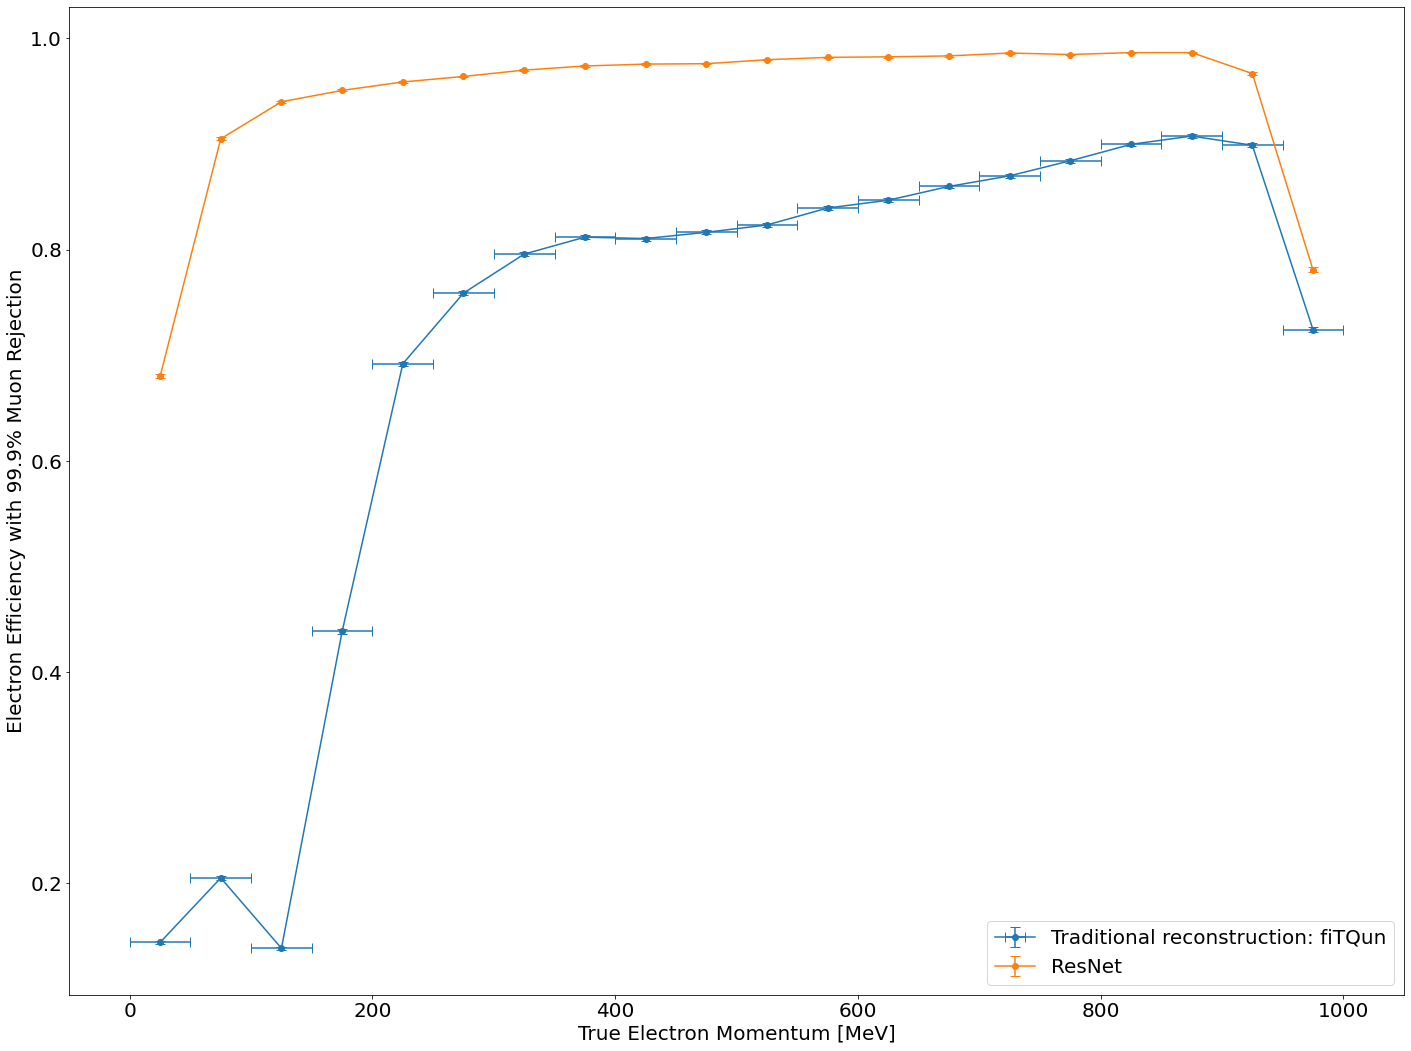

In [26]:
# define the bins for the plot
plot_bin_low = 0
plot_bin_high = 1000
plot_bin_width = 50
plot_bin_lows = np.arange(plot_bin_low, plot_bin_high, plot_bin_width)
plot_bin_centres = np.arange(plot_bin_low + plot_bin_width/2, plot_bin_high, plot_bin_width)
plot_bin_halfwidths = np.full_like(plot_bin_centres, plot_bin_width/2)

# for each particle, each bin, find the events in that bin
plot_bin_selections = [
    (momentum[electrons] > l) & (momentum[electrons] <= l+plot_bin_width)
    for l in plot_bin_lows
]

# for each particle, for each bin, calculate the efficiency rate and the error bar
# for fiTQun
emu_fq_eff_binned = np.array([np.mean(emu_fq_electron_truepositives[c]) for c in plot_bin_selections])
emu_fq_eff_binned_err = np.sqrt(emu_fq_eff_binned*(1-emu_fq_eff_binned)/np.sum(plot_bin_selections, axis=1))
# for ResNet
emu_rn_eff_binned = [np.array([np.mean(emu_rn_electron_truepositives[i][c]) for c in plot_bin_selections]) for i in range(N)]
emu_rn_eff_binned_err = [np.sqrt(emu_rn_eff_binned[i]*(1-emu_rn_eff_binned[i])/np.sum(plot_bin_selections, axis=1)) for i in range(N)]

# plot the results
fig, ax = plt.subplots(figsize=(20,15))
ax.errorbar(plot_bin_centres, emu_fq_eff_binned, yerr=emu_fq_eff_binned_err, xerr=plot_bin_halfwidths,
            label='Traditional reconstruction: fiTQun', fmt='-o', capsize=5)

for i in range(N):
    ax.errorbar(plot_bin_centres, emu_rn_eff_binned[i], yerr=emu_rn_eff_binned_err[i], 
                label=f'{legend[i]}', fmt='-o', capsize=5, color = colors[i])
    
ax.set_xlabel("True Electron Momentum [MeV]")
ax.set_ylabel("Electron Efficiency with 99.9% Muon Rejection")
ax.legend()
fig.tight_layout()

if SAVE_PLOTS:
    plt.savefig('4_class_results/e_vs_muon/true_momentum.jpg',bbox_inches='tight', dpi=150)

### Plot against distance to wall, along particle direction

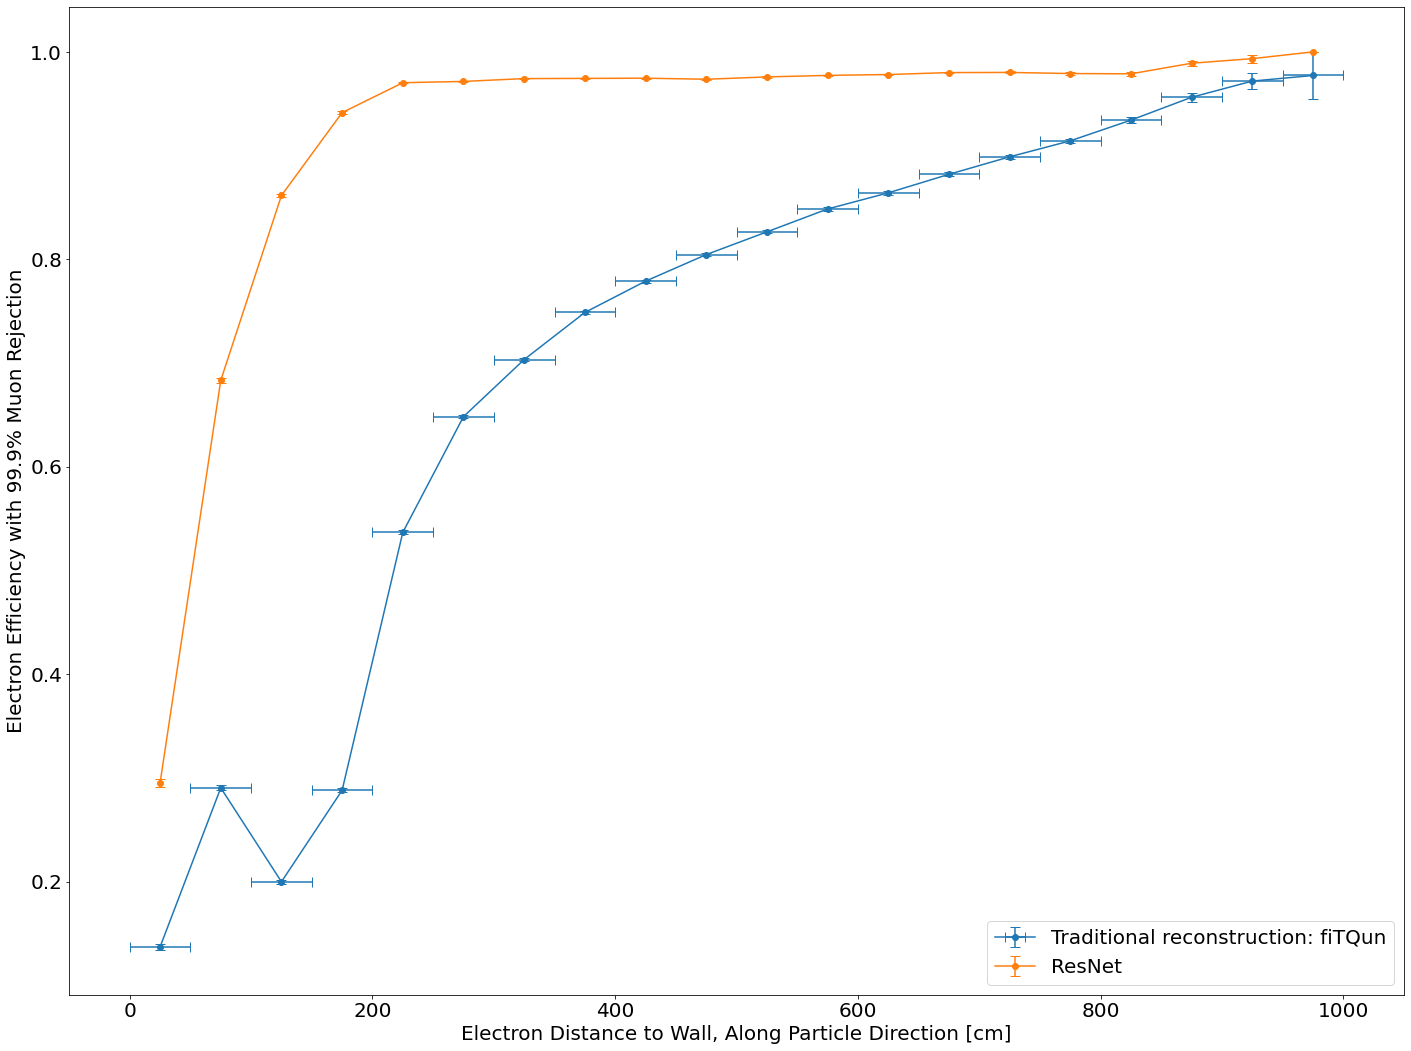

In [27]:
# define the bins for the plot
plot_bin_low = 0
plot_bin_high = 1000
plot_bin_width = 50
plot_bin_lows = np.arange(plot_bin_low, plot_bin_high, plot_bin_width)
plot_bin_centres = np.arange(plot_bin_low + plot_bin_width/2, plot_bin_high, plot_bin_width)
plot_bin_halfwidths = np.full_like(plot_bin_centres, plot_bin_width/2)

# for each particle, each bin, find the events in that bin
plot_bin_selections = [
    (towall[electrons] > l) & (towall[electrons] <= l+plot_bin_width)
    for l in plot_bin_lows
]

# for each particle, for each bin, calculate the efficiency rate and the error bar
# for fiTQun
emu_fq_eff_binned = np.array([np.mean(emu_fq_electron_truepositives[c]) for c in plot_bin_selections])
emu_fq_eff_binned_err = np.sqrt(emu_fq_eff_binned*(1-emu_fq_eff_binned)/np.sum(plot_bin_selections, axis=1))
# for ResNet
emu_rn_eff_binned = [np.array([np.mean(emu_rn_electron_truepositives[i][c]) for c in plot_bin_selections]) for i in range(N)]
emu_rn_eff_binned_err = [np.sqrt(emu_rn_eff_binned[i]*(1-emu_rn_eff_binned[i])/np.sum(plot_bin_selections, axis=1)) for i in range(N)]

# plot the results
fig, ax = plt.subplots(figsize=(20,15))
ax.errorbar(plot_bin_centres, emu_fq_eff_binned, yerr=emu_fq_eff_binned_err, xerr=plot_bin_halfwidths,
            label='Traditional reconstruction: fiTQun', fmt='-o', capsize=5)

for i in range(N):
    ax.errorbar(plot_bin_centres, emu_rn_eff_binned[i], yerr=emu_rn_eff_binned_err[i], 
                label=f'{legend[i]}', fmt='-o', capsize=5, color = colors[i])
    
ax.set_xlabel("Electron Distance to Wall, Along Particle Direction [cm]")
ax.set_ylabel("Electron Efficiency with 99.9% Muon Rejection")
ax.legend()
fig.tight_layout()

if SAVE_PLOTS:
    plt.savefig('4_class_results/e_vs_muon/towall.jpg',bbox_inches='tight', dpi=150)

### Plot against dwall

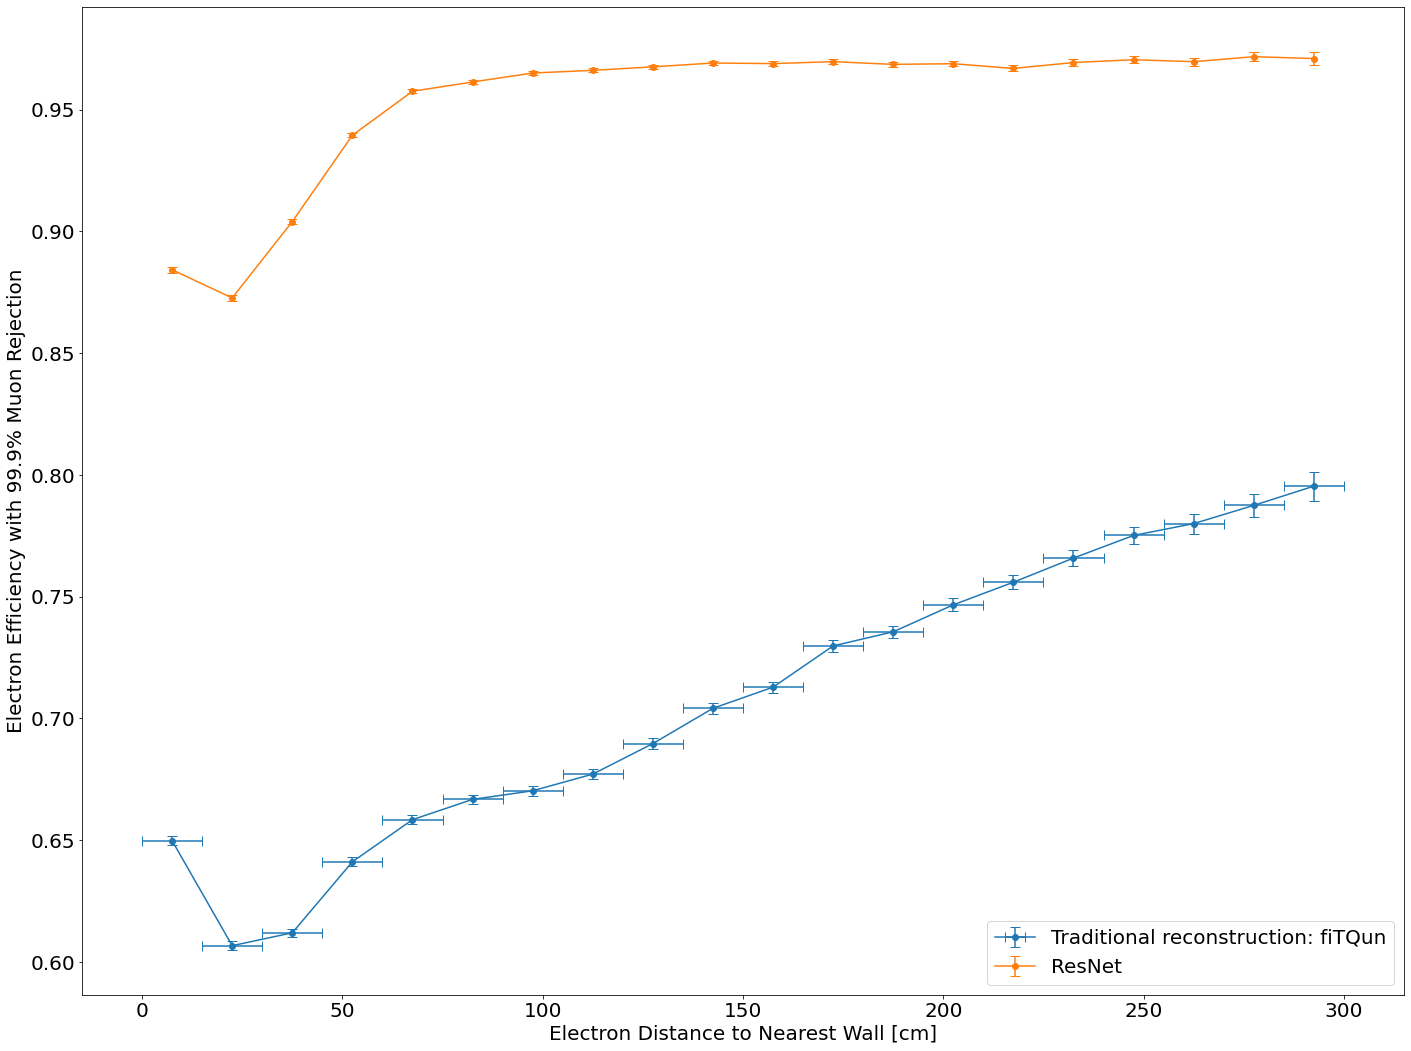

In [28]:
# define the bins for the plot
plot_bin_low = 0
plot_bin_high = 300
plot_bin_width = 15
plot_bin_lows = np.arange(plot_bin_low, plot_bin_high, plot_bin_width)
plot_bin_centres = np.arange(plot_bin_low + plot_bin_width/2, plot_bin_high, plot_bin_width)
plot_bin_halfwidths = np.full_like(plot_bin_centres, plot_bin_width/2)

# for each particle, each bin, find the events in that bin
plot_bin_selections = [
    (dwall[electrons] > l) & (dwall[electrons] <= l+plot_bin_width)
    for l in plot_bin_lows
]

# for each particle, for each bin, calculate the efficiency rate and the error bar
# for fiTQun
emu_fq_eff_binned = np.array([np.mean(emu_fq_electron_truepositives[c]) for c in plot_bin_selections])
emu_fq_eff_binned_err = np.sqrt(emu_fq_eff_binned*(1-emu_fq_eff_binned)/np.sum(plot_bin_selections, axis=1))
# for ResNet
emu_rn_eff_binned = [np.array([np.mean(emu_rn_electron_truepositives[i][c]) for c in plot_bin_selections]) for i in range(N)]
emu_rn_eff_binned_err = [np.sqrt(emu_rn_eff_binned[i]*(1-emu_rn_eff_binned[i])/np.sum(plot_bin_selections, axis=1)) for i in range(N)]

# plot the results
fig, ax = plt.subplots(figsize=(20,15))
ax.errorbar(plot_bin_centres, emu_fq_eff_binned, yerr=emu_fq_eff_binned_err, xerr=plot_bin_halfwidths,
            label='Traditional reconstruction: fiTQun', fmt='-o', capsize=5)

for i in range(N):
    ax.errorbar(plot_bin_centres, emu_rn_eff_binned[i], yerr=emu_rn_eff_binned_err[i], 
                label=f'{legend[i]}', fmt='-o', capsize=5, color = colors[i])
    
ax.set_xlabel("Electron Distance to Nearest Wall [cm]")
ax.set_ylabel("Electron Efficiency with 99.9% Muon Rejection")
ax.legend()
fig.tight_layout()

if SAVE_PLOTS:
    plt.savefig('4_class_results/e_vs_muon/dwall.jpg',bbox_inches='tight', dpi=150)

### Plot against zenith

In [29]:
zenith = np.cos(h5_angles[:,0])

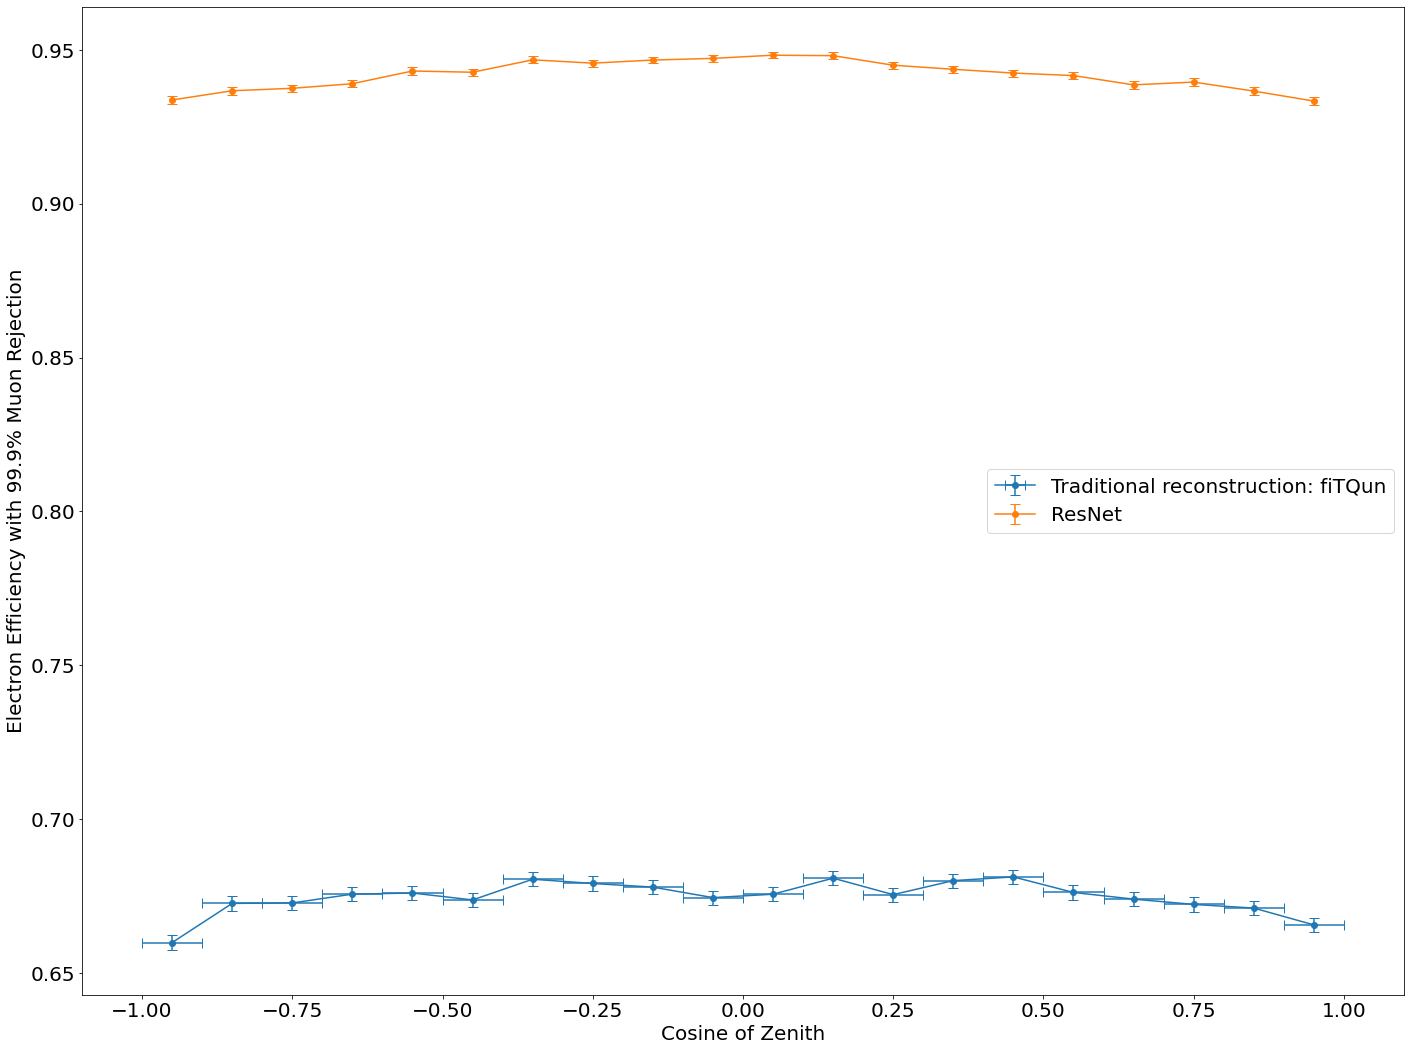

In [30]:
# define the bins for the plot
plot_bin_low = -1
plot_bin_high = 1
plot_bin_width = 1/10
plot_bin_lows = np.arange(plot_bin_low, plot_bin_high, plot_bin_width)
plot_bin_centres = np.arange(plot_bin_low + plot_bin_width/2, plot_bin_high, plot_bin_width)
plot_bin_halfwidths = np.full_like(plot_bin_centres, plot_bin_width/2)

# for each particle, each bin, find the events in that bin
plot_bin_selections = [
    (zenith[electrons] > l) & (zenith[electrons] <= l+plot_bin_width)
    for l in plot_bin_lows
]

# for each particle, for each bin, calculate the efficiency rate and the error bar
# for fiTQun
emu_fq_eff_binned = np.array([np.mean(emu_fq_electron_truepositives[c]) for c in plot_bin_selections])
emu_fq_eff_binned_err = np.sqrt(emu_fq_eff_binned*(1-emu_fq_eff_binned)/np.sum(plot_bin_selections, axis=1))
# for ResNet
emu_rn_eff_binned = [np.array([np.mean(emu_rn_electron_truepositives[i][c]) for c in plot_bin_selections]) for i in range(N)]
emu_rn_eff_binned_err = [np.sqrt(emu_rn_eff_binned[i]*(1-emu_rn_eff_binned[i])/np.sum(plot_bin_selections, axis=1)) for i in range(N)]

# plot the results
fig, ax = plt.subplots(figsize=(20,15))
ax.errorbar(plot_bin_centres, emu_fq_eff_binned, yerr=emu_fq_eff_binned_err, xerr=plot_bin_halfwidths,
            label='Traditional reconstruction: fiTQun', fmt='-o', capsize=5)

for i in range(N):
    ax.errorbar(plot_bin_centres, emu_rn_eff_binned[i], yerr=emu_rn_eff_binned_err[i], 
                label=f'{legend[i]}', fmt='-o', capsize=5, color=colors[i])
    
ax.set_xlabel("Cosine of Zenith")
ax.set_ylabel("Electron Efficiency with 99.9% Muon Rejection")
ax.legend()
fig.tight_layout()

if SAVE_PLOTS:
    plt.savefig('4_class_results/e_vs_muon/zenith.jpg',bbox_inches='tight', dpi=150)

### Plot against Azimuth

In [31]:
azimuth = h5_angles[:,1]

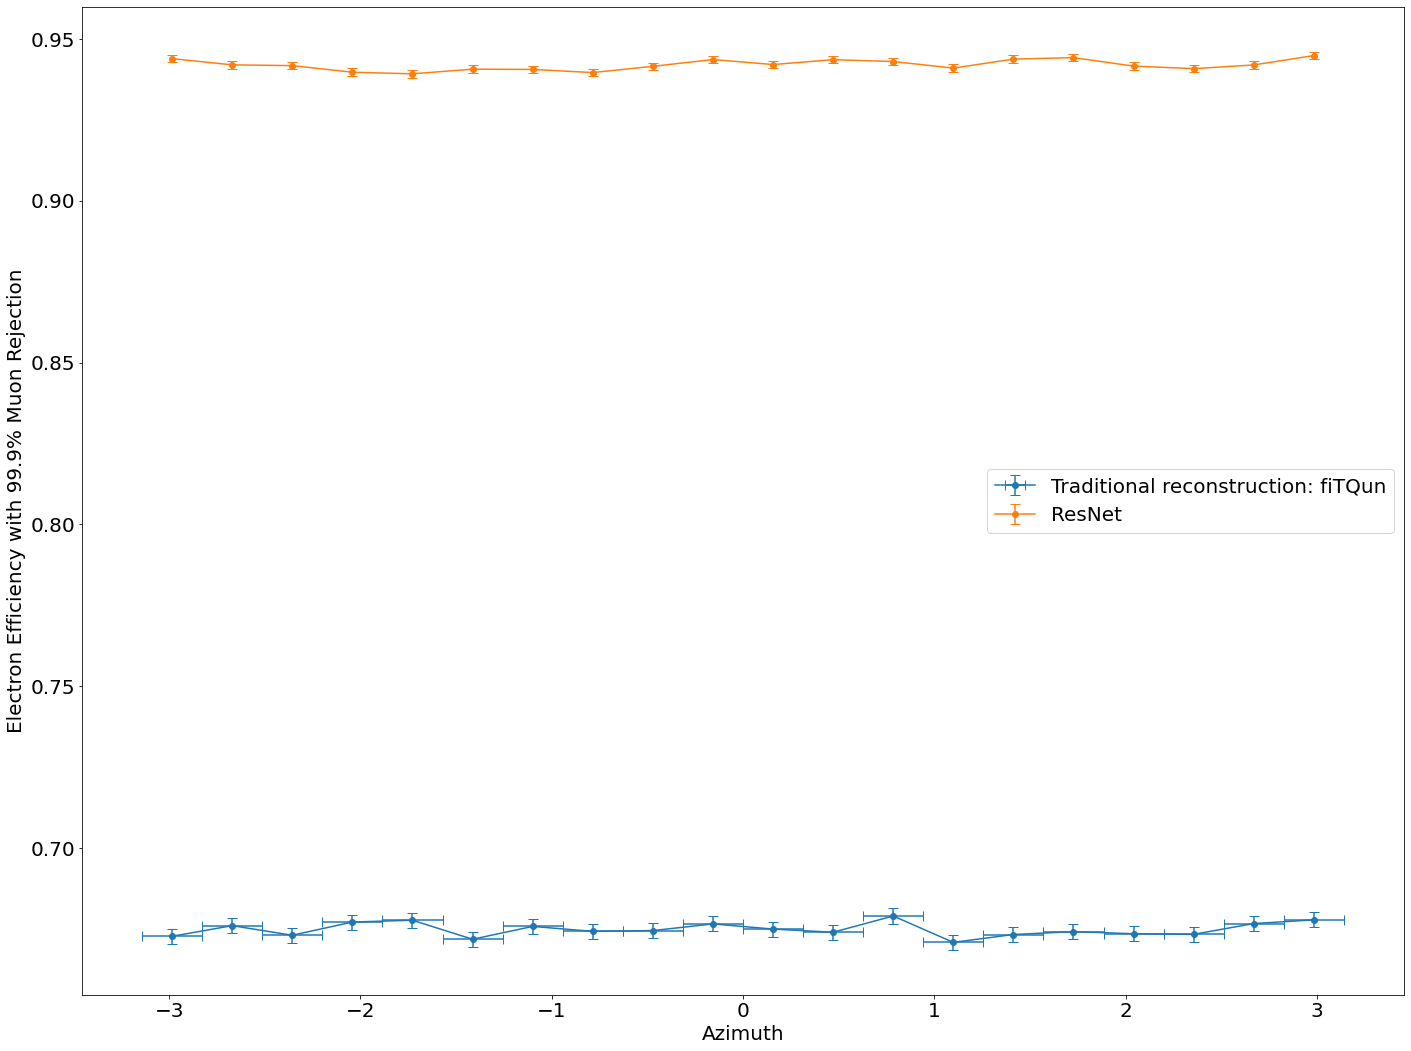

In [32]:
# define the bins for the plot
plot_bin_low = -np.pi
plot_bin_high = np.pi
plot_bin_width = np.pi/10
plot_bin_lows = np.arange(plot_bin_low, plot_bin_high, plot_bin_width)
plot_bin_centres = np.arange(plot_bin_low + plot_bin_width/2, plot_bin_high, plot_bin_width)
plot_bin_halfwidths = np.full_like(plot_bin_centres, plot_bin_width/2)

# for each particle, each bin, find the events in that bin
plot_bin_selections = [
    (azimuth[electrons] > l) & (azimuth[electrons] <= l+plot_bin_width)
    for l in plot_bin_lows
]

# for each particle, for each bin, calculate the efficiency rate and the error bar
# for fiTQun
emu_fq_eff_binned = np.array([np.mean(emu_fq_electron_truepositives[c]) for c in plot_bin_selections])
emu_fq_eff_binned_err = np.sqrt(emu_fq_eff_binned*(1-emu_fq_eff_binned)/np.sum(plot_bin_selections, axis=1))
# for ResNet
emu_rn_eff_binned = [np.array([np.mean(emu_rn_electron_truepositives[i][c]) for c in plot_bin_selections]) for i in range(N)]
emu_rn_eff_binned_err = [np.sqrt(emu_rn_eff_binned[i]*(1-emu_rn_eff_binned[i])/np.sum(plot_bin_selections, axis=1)) for i in range(N)]

# plot the results
fig, ax = plt.subplots(figsize=(20,15))
ax.errorbar(plot_bin_centres, emu_fq_eff_binned, yerr=emu_fq_eff_binned_err, xerr=plot_bin_halfwidths,
            label='Traditional reconstruction: fiTQun', fmt='-o', capsize=5)

for i in range(N):
    ax.errorbar(plot_bin_centres, emu_rn_eff_binned[i], yerr=emu_rn_eff_binned_err[i], 
                label=f'{legend[i]}', fmt='-o', capsize=5, color=colors[i])
    
ax.set_xlabel("Azimuth")
ax.set_ylabel("Electron Efficiency with 99.9% Muon Rejection")
ax.legend()
fig.tight_layout()

if SAVE_PLOTS:
    plt.savefig('4_class_results/e_vs_muon/azimuth.jpg',bbox_inches='tight', dpi=150)

## Electron vs Gamma

### ROC curve for electron signal vs gamma rejection

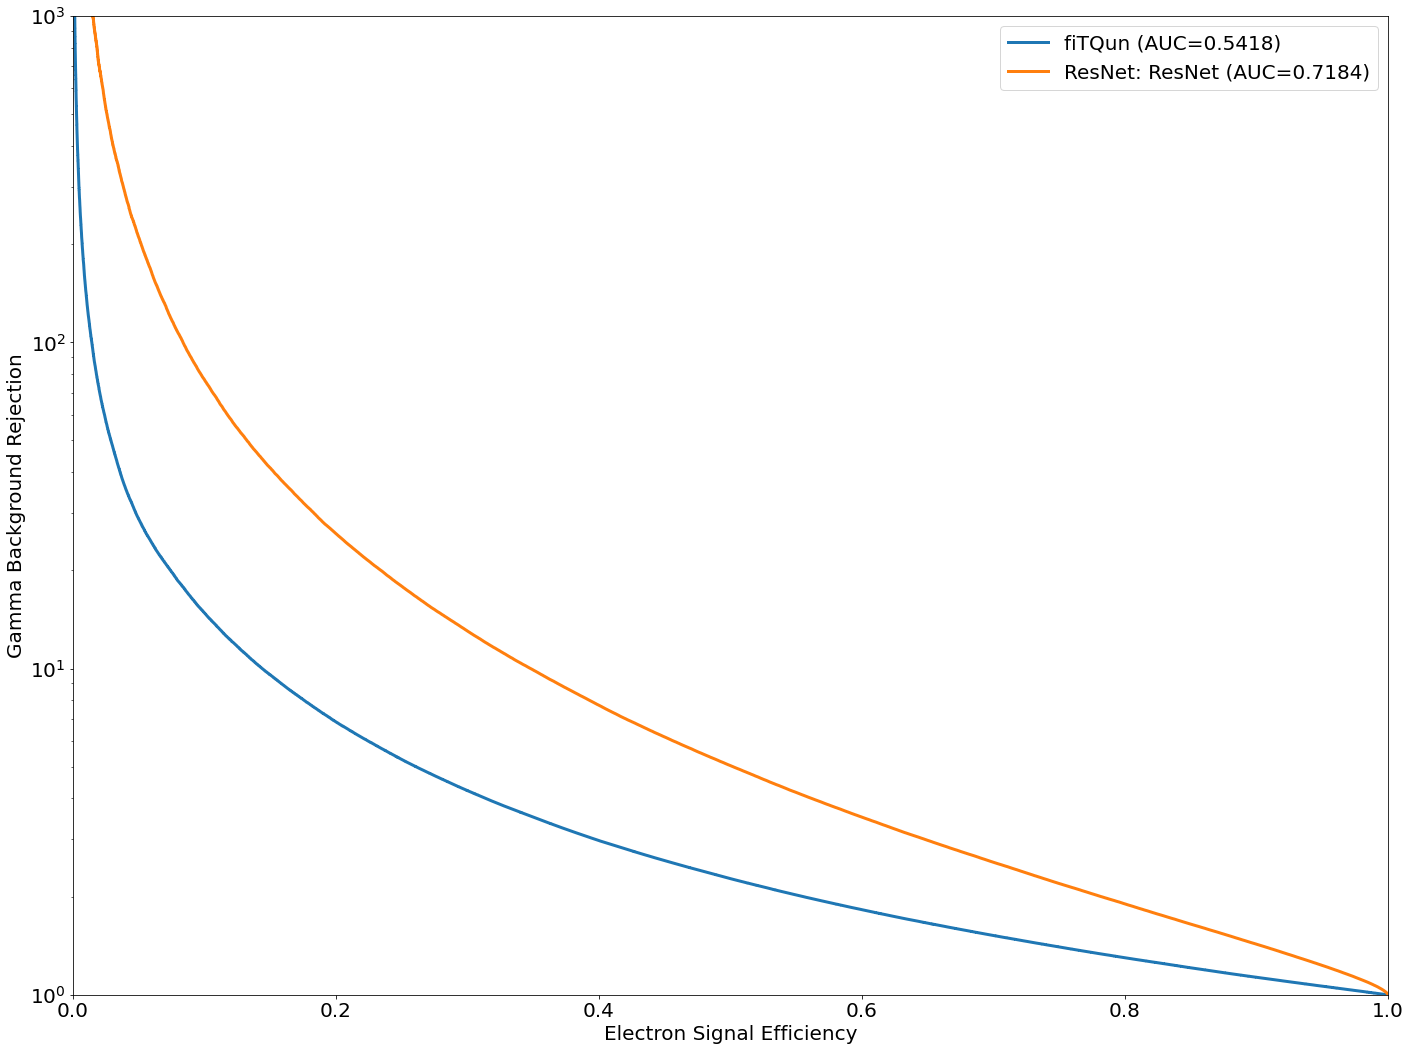

In [33]:
# the electron-like discriminator is the negative log-likelihood difference for fiTQun (es are more mu-like...)
eg_nll = h5_e_nll-h5_mu_nll
# the electron-like discriminator for ResNet is:
# [electron softmax]/([electron softmax] + [gamma softmax])
eg_elike = [softmaxes[i][:,1]/(softmaxes[i][:,1] + softmaxes[i][:,0]) for i in range(N)]

# get the true and false positives
eg_fq_roc_fpr, eg_fq_roc_tpr, _ = metrics.roc_curve(h5_labels[eg_cut]==1, eg_nll[eg_cut])

eg_rn_roc_fpr, eg_rn_roc_tpr = [],[]
for i in range(N):
    fpr,tpr, _ = metrics.roc_curve(h5_labels[eg_cut]==1, eg_elike[i][eg_cut])
    eg_rn_roc_fpr.append(fpr)
    eg_rn_roc_tpr.append(tpr)
    
# get the AUC
eg_fq_auc = metrics.auc(eg_fq_roc_fpr, eg_fq_roc_tpr)
eg_rn_auc = [metrics.auc(eg_rn_roc_fpr[i], eg_rn_roc_tpr[i]) for i in range(N)]

with np.errstate(divide='ignore'):
    eg_fq_bgr = 1/eg_fq_roc_fpr
    eg_rn_bgr = [1/eg_rn_roc_fpr[i] for i in range(N)]

# plot the results
fig, ax = plt.subplots(figsize=(20,15))
ax.plot(eg_fq_roc_tpr, eg_fq_bgr, label=f"fiTQun (AUC={eg_fq_auc:.4f})", lw=3)

for i in range(N):
    ax.plot(eg_rn_roc_tpr[i], eg_rn_bgr[i], label=f"ResNet: {legend[i]} (AUC={eg_rn_auc[i]:.4f})",color=colors[i],lw=3)

ax.set_xlabel("Electron Signal Efficiency")
ax.set_ylabel("Gamma Background Rejection")
ax.set_yscale('log')
ax.set_ylim((1,1000))
ax.set_xlim((0.0,1))
ax.legend()
fig.tight_layout()

if SAVE_PLOTS:
    plt.savefig('4_class_results/e_vs_gamma/roc1.jpg',bbox_inches='tight', dpi=150)

### ROC curve for gamma signal vs electron rejection

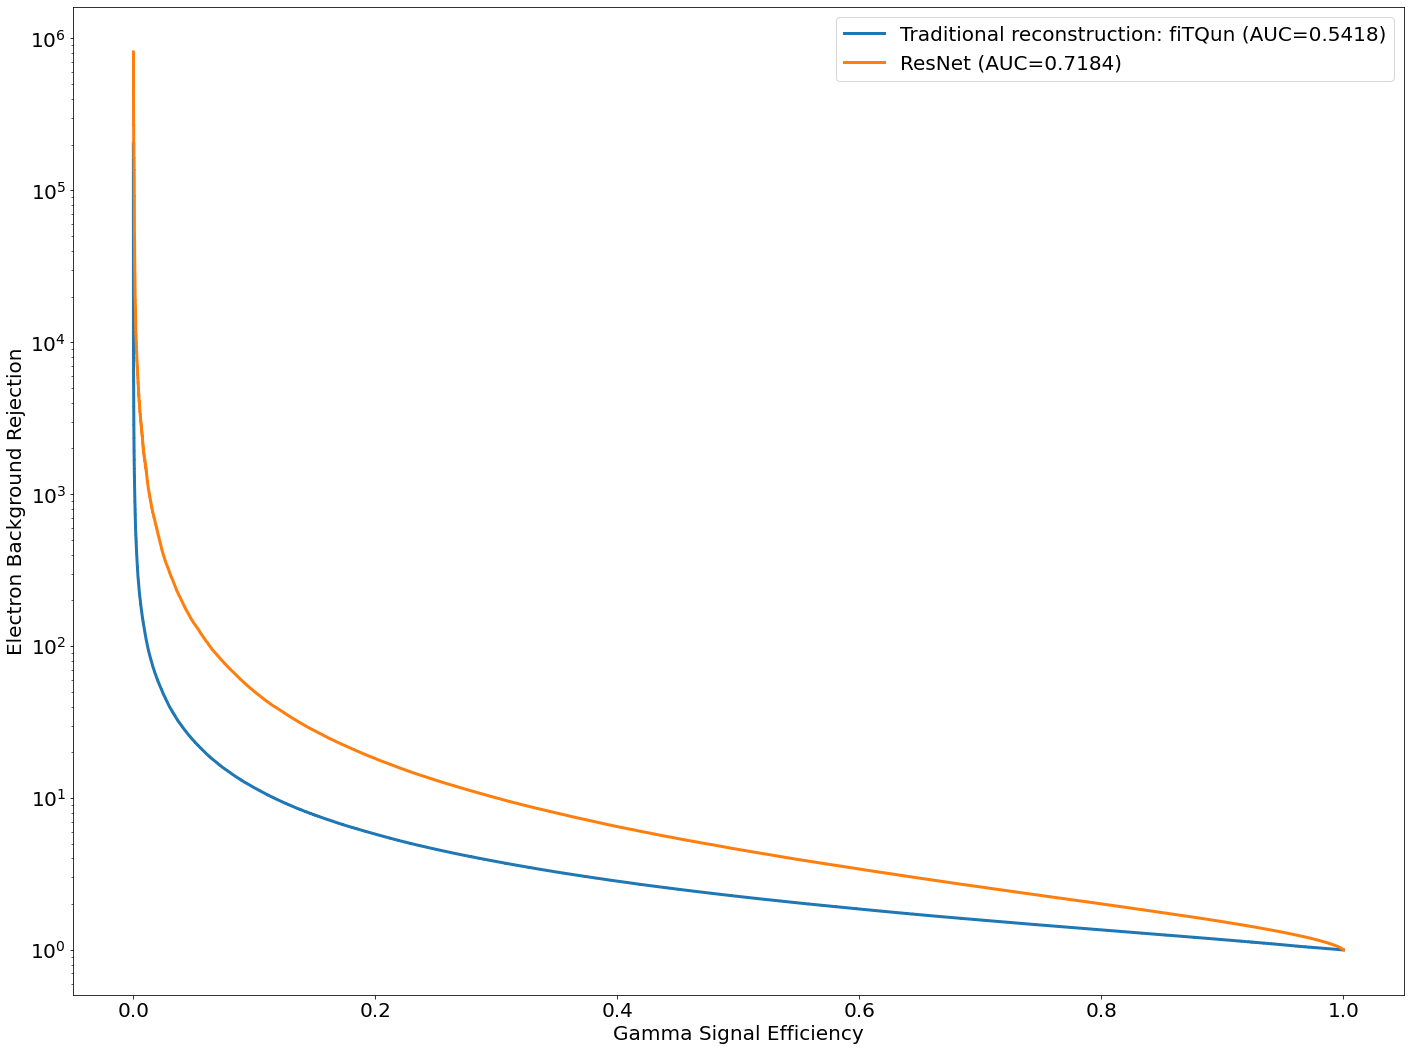

In [34]:
# the electron-like discriminator is the ngeative log-likelihood difference for fiTQun (es are more mu-like...)
ge_nll = h5_mu_nll-h5_e_nll
# the electron-like discriminator for ResNet is:
# [electron softmax]/([electron softmax] + [gamma softmax])
ge_elike = [softmaxes[i][:,0]/(softmaxes[i][:,1] + softmaxes[i][:,0]) for i in range(N)]

# get the true and false positives
ge_fq_roc_fpr, ge_fq_roc_tpr, _ = metrics.roc_curve(h5_labels[ge_cut]==0, ge_nll[ge_cut])

ge_rn_roc_fpr, ge_rn_roc_tpr = [],[]
for i in range(N):
    fpr, tpr, _ = metrics.roc_curve(h5_labels[ge_cut]==0, ge_elike[i][ge_cut])
    ge_rn_roc_fpr.append(fpr)
    ge_rn_roc_tpr.append(tpr)

# get the AUC
ge_fq_auc = metrics.auc(ge_fq_roc_fpr, ge_fq_roc_tpr)
ge_rn_auc = [metrics.auc(ge_rn_roc_fpr[i], ge_rn_roc_tpr[i]) for i in range(N)]

with np.errstate(divide='ignore'):
    ge_fq_bgr = 1/ge_fq_roc_fpr
    ge_rn_bgr = [1/ge_rn_roc_fpr[i] for i in range(N)]

# plot the results
fig, ax = plt.subplots(figsize=(20,15))
ax.plot(ge_fq_roc_tpr, ge_fq_bgr, label=f"Traditional reconstruction: fiTQun (AUC={ge_fq_auc:.4f})",lw=3)
for i in range(N):
    ax.plot(ge_rn_roc_tpr[i], ge_rn_bgr[i], label=f"{legend[i]} (AUC={ge_rn_auc[i]:.4f})",color=colors[i],lw=3)

ax.set_xlabel("Gamma Signal Efficiency")
ax.set_ylabel("Electron Background Rejection")
ax.set_yscale('log')
# ax.set_ylim((1,100))
ax.legend()
fig.tight_layout()

if SAVE_PLOTS:
    plt.savefig('4_class_results/e_vs_gamma/roc2.jpg',bbox_inches='tight', dpi=150)

###  for fixed 20% gamma mis-ID

### for each 50 MeV bin of reconstructed momentum, calculate the thresholds for fiTQun

In [35]:
# the electron-like discriminator is the negative log-likelihood difference for fiTQun (es are more mu-like...)
eg_nll = h5_e_nll-h5_mu_nll

# set up the bins
eg_bin_low = 0
eg_bin_high = 1000
eg_bin_width = 50
eg_bin_lows = np.arange(eg_bin_low, eg_bin_high, eg_bin_width)

# for each particle type, for each bin, make a boolean array to say whether each event belongs in that bin
eg_e_bin_selections = [
    (h5_reco_mom_e[electrons] > l) & (h5_reco_mom_e[electrons] <= l+eg_bin_width)
    for l in eg_bin_lows
]
eg_gamma_bin_selections = [
    (h5_reco_mom_e[gammas] > l) & (h5_reco_mom_e[gammas] <= l+eg_bin_width)
    for l in eg_bin_lows
]

# for each bin, the threshold that gives 20% mis-ID (80% are below the threshold)
eg_fq_thresholds = [np.quantile(eg_nll[gammas][c], 0.8) for c in eg_gamma_bin_selections]

# for each particle type, for each bin, make a, boolean array to say whether each event is below the threshold
# start by filling it full of false
eg_fq_electron_truepositives = np.zeros_like(eg_nll[electrons]).astype(bool)
eg_fq_gamma_falsepositives = np.zeros_like(eg_nll[gammas]).astype(bool)
# then loop over the bins and set to true for the events in those bins that are over the threshold
for t, c in zip(eg_fq_thresholds, eg_e_bin_selections):
    eg_fq_electron_truepositives[c] = eg_nll[electrons][c] > t
for t, c in zip(eg_fq_thresholds, eg_gamma_bin_selections):
    eg_fq_gamma_falsepositives[c] = eg_nll[gammas][c] > t

### calculate the thresholds for ResNet

In [36]:
# the electron-like discriminator for ResNet is:
# [electron softmax]/([electron softmax] + [gamma softmax])
eg_elike = [softmaxes[i][:,1]/(softmaxes[i][:,1] + softmaxes[i][:,0]) for i in range(N)]

# for each bin, the threshold that gives 20% mis-ID (80% are below the threshold)
eg_rn_thresholds = [
    [np.quantile(eg_elike[i][gammas][c], 0.8) for c in eg_gamma_bin_selections] for i in range(N)
]

# for each particle type, for each bin, make a, boolean array to say whether each event is below the threshold
# start by filling it full of false
eg_rn_electron_truepositives = [np.zeros_like(eg_elike[i][electrons]).astype(bool) for i in range(N)]
eg_rn_gamma_falsepositives = [np.zeros_like(eg_elike[i][gammas]).astype(bool) for i in range(N)]
# then loop over the bins and set to true for the events in those bins that are over the threshold

for i in range(N):
    for t, c in zip(eg_rn_thresholds[i], eg_e_bin_selections):
        eg_rn_electron_truepositives[i][c] = eg_elike[i][electrons][c] > t
        
for i in range(N):
    for t, c in zip(eg_rn_thresholds[i], eg_gamma_bin_selections):
        eg_rn_gamma_falsepositives[i][c] = eg_elike[i][gammas][c] > t

### Plot against true momentum

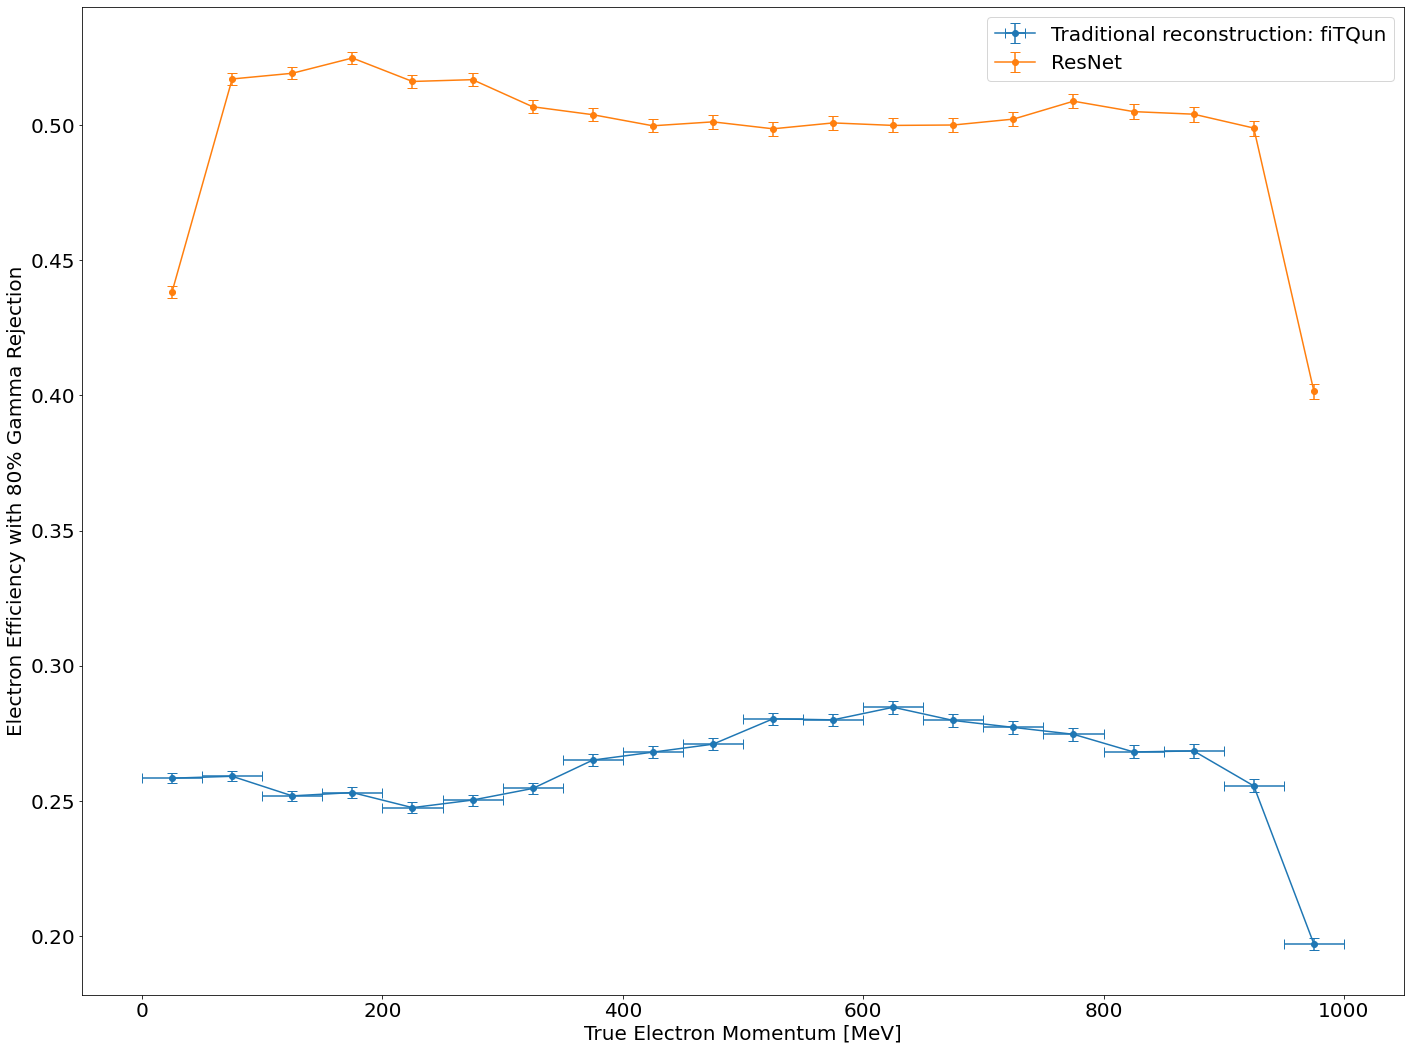

In [37]:
# define the bins for the plot
plot_bin_low = 0
plot_bin_high = 1000
plot_bin_width = 50
plot_bin_lows = np.arange(plot_bin_low, plot_bin_high, plot_bin_width)
plot_bin_centres = np.arange(plot_bin_low + plot_bin_width/2, plot_bin_high, plot_bin_width)
plot_bin_halfwidths = np.full_like(plot_bin_centres, plot_bin_width/2)

# for each particle, each bin, find the events in that bin
plot_bin_selections = [
    (momentum[electrons] > l) & (momentum[electrons] <= l+plot_bin_width)
    for l in plot_bin_lows
]

# for each particle, for each bin, calculate the efficiency rate and the error bar
# for fiTQun
eg_fq_eff_binned = np.array([np.mean(eg_fq_electron_truepositives[c]) for c in plot_bin_selections])
eg_fq_eff_binned_err = np.sqrt(eg_fq_eff_binned*(1-eg_fq_eff_binned)/np.sum(plot_bin_selections, axis=1))
# for ResNet
eg_rn_eff_binned = [np.array([np.mean(eg_rn_electron_truepositives[i][c]) for c in plot_bin_selections]) 
                    for i in range(N)]
eg_rn_eff_binned_err = [np.sqrt(eg_rn_eff_binned[i]*(1-eg_rn_eff_binned[i])/np.sum(plot_bin_selections, axis=1))
                        for i in range(N)]

# plot the results
fig, ax = plt.subplots(figsize=(20,15))
ax.errorbar(plot_bin_centres, eg_fq_eff_binned, yerr=eg_fq_eff_binned_err, xerr=plot_bin_halfwidths,
            label='Traditional reconstruction: fiTQun', fmt='-o', capsize=5)

for i in range(N):
    ax.errorbar(plot_bin_centres, eg_rn_eff_binned[i], yerr=eg_rn_eff_binned_err[i],
                label=f'{legend[i]}', fmt='-o', capsize=5,color=colors[i])
    
ax.set_xlabel("True Electron Momentum [MeV]")
ax.set_ylabel("Electron Efficiency with 80% Gamma Rejection")
ax.legend()
fig.tight_layout()

if SAVE_PLOTS:
    plt.savefig('4_class_results/e_vs_gamma/true_momentum.jpg',bbox_inches='tight', dpi=150)

### Plot against towall

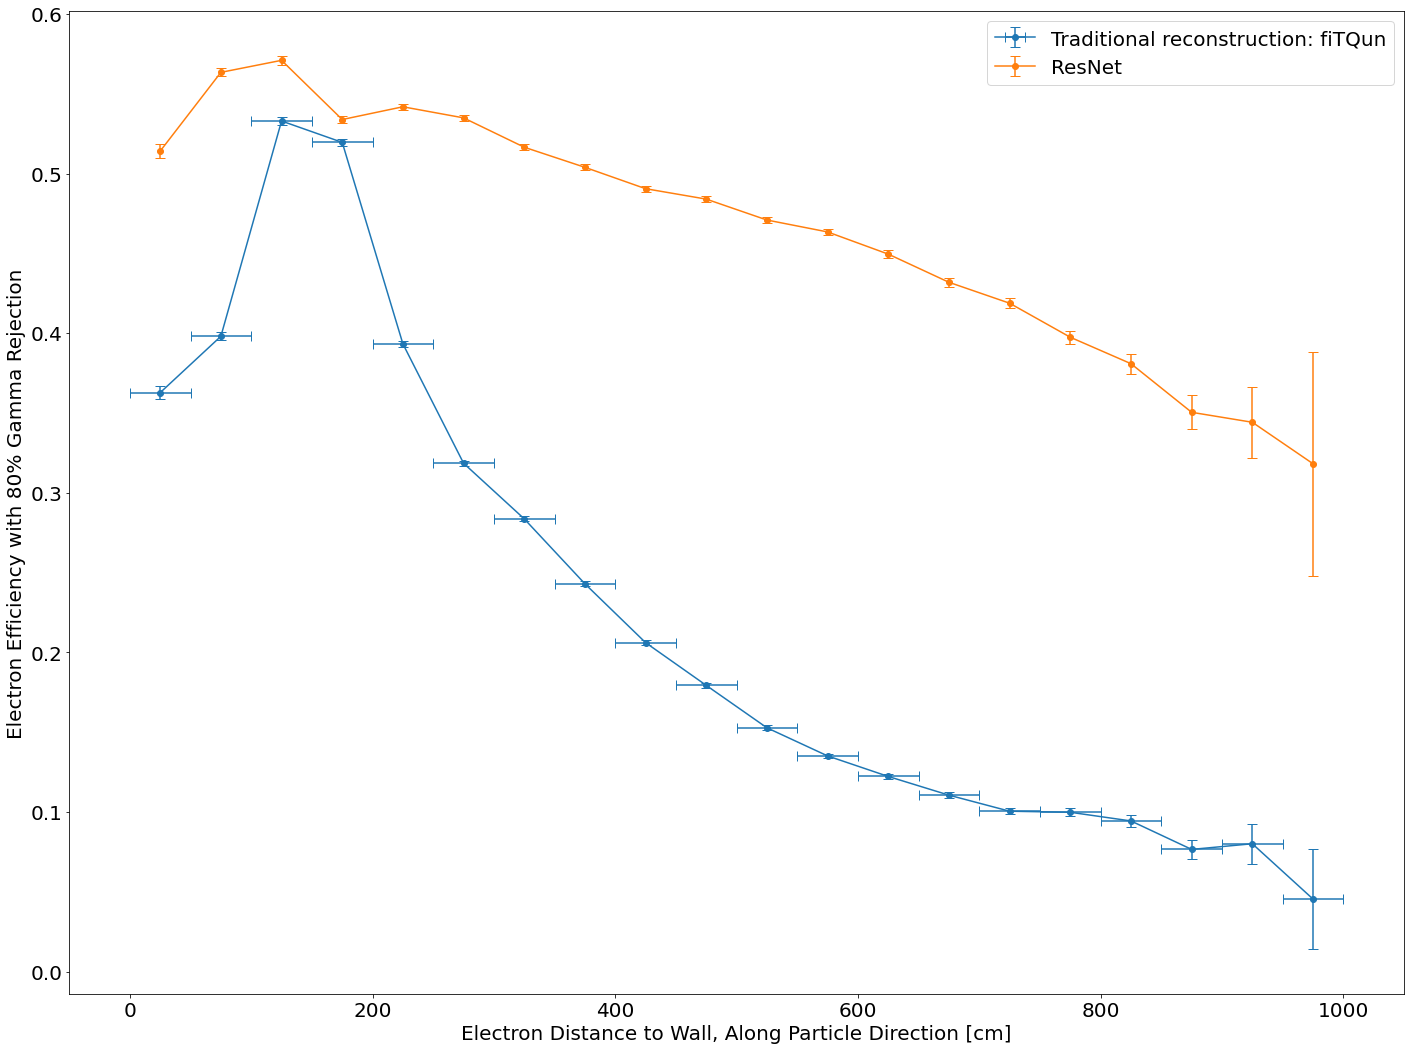

In [38]:
# define the bins for the plot
plot_bin_low = 0
plot_bin_high = 1000
plot_bin_width = 50
plot_bin_lows = np.arange(plot_bin_low, plot_bin_high, plot_bin_width)
plot_bin_centres = np.arange(plot_bin_low + plot_bin_width/2, plot_bin_high, plot_bin_width)
plot_bin_halfwidths = np.full_like(plot_bin_centres, plot_bin_width/2)

# for each particle, each bin, find the events in that bin
plot_bin_selections = [
    (towall[electrons] > l) & (towall[electrons] <= l+plot_bin_width)
    for l in plot_bin_lows
]

# for each particle, for each bin, calculate the efficiency rate and the error bar
# for fiTQun
eg_fq_eff_binned = np.array([np.mean(eg_fq_electron_truepositives[c]) for c in plot_bin_selections])
eg_fq_eff_binned_err = np.sqrt(eg_fq_eff_binned*(1-eg_fq_eff_binned)/np.sum(plot_bin_selections, axis=1))
# for ResNet
eg_rn_eff_binned = [np.array([np.mean(eg_rn_electron_truepositives[i][c]) for c in plot_bin_selections]) 
                    for i in range(N)]
eg_rn_eff_binned_err = [np.sqrt(eg_rn_eff_binned[i]*(1-eg_rn_eff_binned[i])/np.sum(plot_bin_selections, axis=1))
                        for i in range(N)]

# plot the results
fig, ax = plt.subplots(figsize=(20,15))
ax.errorbar(plot_bin_centres, eg_fq_eff_binned, yerr=eg_fq_eff_binned_err, xerr=plot_bin_halfwidths,
            label='Traditional reconstruction: fiTQun', fmt='-o', capsize=5)

for i in range(N):
    ax.errorbar(plot_bin_centres, eg_rn_eff_binned[i], yerr=eg_rn_eff_binned_err[i],
                label=f'{legend[i]}', fmt='-o', capsize=5,color=colors[i])
    
ax.set_xlabel("Electron Distance to Wall, Along Particle Direction [cm]")
ax.set_ylabel("Electron Efficiency with 80% Gamma Rejection")
ax.legend()
fig.tight_layout()

if SAVE_PLOTS:
    plt.savefig('4_class_results/e_vs_gamma/towall.jpg',bbox_inches='tight', dpi=150)

### Plot against dwall

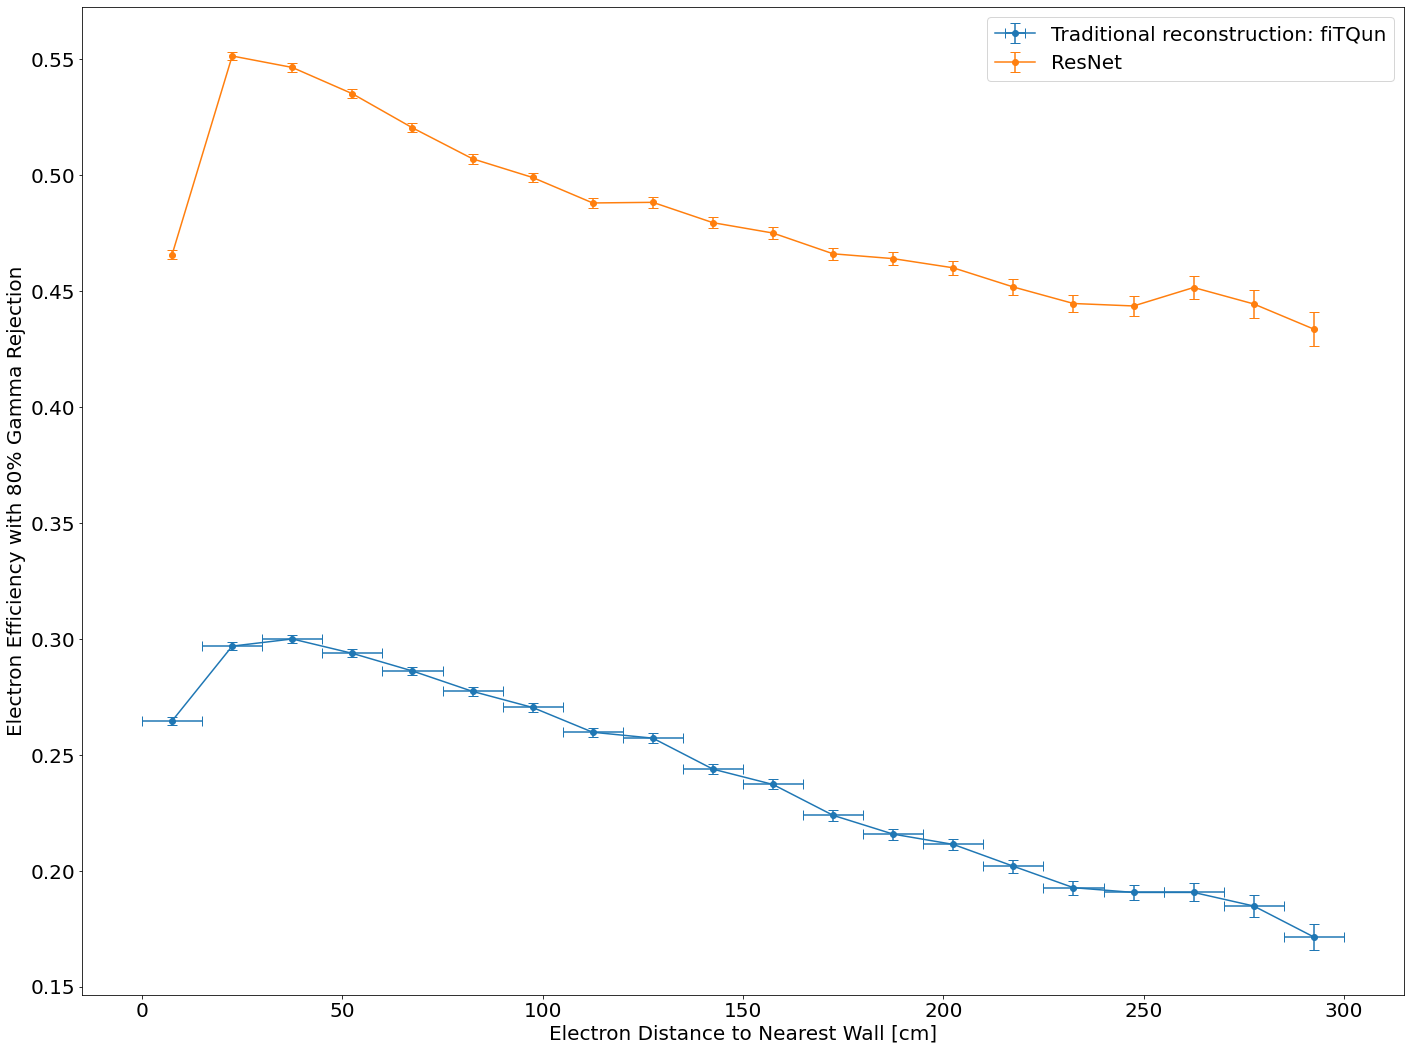

In [39]:
# define the bins for the plot
plot_bin_low = 0
plot_bin_high = 300
plot_bin_width = 15
plot_bin_lows = np.arange(plot_bin_low, plot_bin_high, plot_bin_width)
plot_bin_centres = np.arange(plot_bin_low + plot_bin_width/2, plot_bin_high, plot_bin_width)
plot_bin_halfwidths = np.full_like(plot_bin_centres, plot_bin_width/2)

# for each particle, each bin, find the events in that bin
plot_bin_selections = [
    (dwall[electrons] > l) & (dwall[electrons] <= l+plot_bin_width)
    for l in plot_bin_lows
]

# for each particle, for each bin, calculate the efficiency rate and the error bar
# for fiTQun
eg_fq_eff_binned = np.array([np.mean(eg_fq_electron_truepositives[c]) for c in plot_bin_selections])
eg_fq_eff_binned_err = np.sqrt(eg_fq_eff_binned*(1-eg_fq_eff_binned)/np.sum(plot_bin_selections, axis=1))
# for ResNet
eg_rn_eff_binned = [np.array([np.mean(eg_rn_electron_truepositives[i][c]) for c in plot_bin_selections]) 
                    for i in range(N)]
eg_rn_eff_binned_err = [np.sqrt(eg_rn_eff_binned[i]*(1-eg_rn_eff_binned[i])/np.sum(plot_bin_selections, axis=1))
                        for i in range(N)]

# plot the results
fig, ax = plt.subplots(figsize=(20,15))
ax.errorbar(plot_bin_centres, eg_fq_eff_binned, yerr=eg_fq_eff_binned_err, xerr=plot_bin_halfwidths,
            label='Traditional reconstruction: fiTQun', fmt='-o', capsize=5)

for i in range(N):
    ax.errorbar(plot_bin_centres, eg_rn_eff_binned[i], yerr=eg_rn_eff_binned_err[i],
                label=f'{legend[i]}', fmt='-o', capsize=5,color=colors[i])
    
ax.set_xlabel("Electron Distance to Nearest Wall [cm]")
ax.set_ylabel("Electron Efficiency with 80% Gamma Rejection")
ax.legend()
fig.tight_layout()

if SAVE_PLOTS:
    plt.savefig('4_class_results/e_vs_gamma/dwall.jpg',bbox_inches='tight', dpi=150)

### Plot against zenith

In [40]:
zenith = np.cos(h5_angles[:,0])

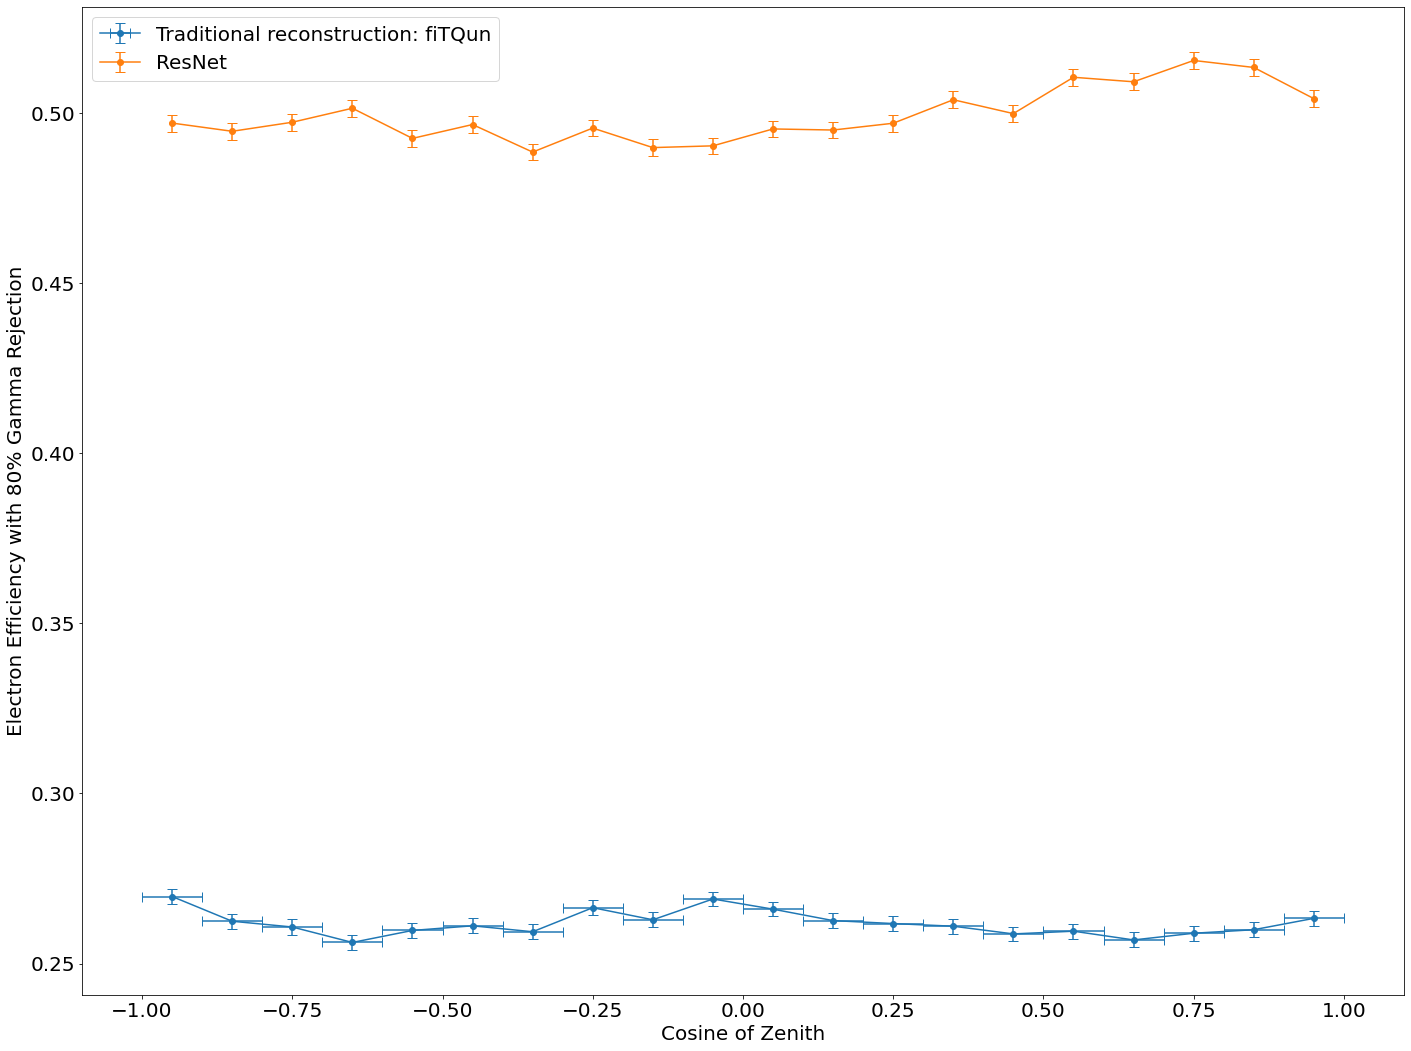

In [41]:
# define the bins for the plot
plot_bin_low = -1
plot_bin_high = 1
plot_bin_width = 1/10
plot_bin_lows = np.arange(plot_bin_low, plot_bin_high, plot_bin_width)
plot_bin_centres = np.arange(plot_bin_low + plot_bin_width/2, plot_bin_high, plot_bin_width)
plot_bin_halfwidths = np.full_like(plot_bin_centres, plot_bin_width/2)

# for each particle, each bin, find the events in that bin
plot_bin_selections = [
    (zenith[electrons] > l) & (zenith[electrons] <= l+plot_bin_width)
    for l in plot_bin_lows
]

# for each particle, for each bin, calculate the efficiency rate and the error bar
# for fiTQun
eg_fq_eff_binned = np.array([np.mean(eg_fq_electron_truepositives[c]) for c in plot_bin_selections])
eg_fq_eff_binned_err = np.sqrt(eg_fq_eff_binned*(1-eg_fq_eff_binned)/np.sum                               (plot_bin_selections, axis=1))
# for ResNet
eg_rn_eff_binned = [np.array([np.mean(eg_rn_electron_truepositives[i][c]) for c in plot_bin_selections])
                   for i in range(N)]
eg_rn_eff_binned_err = [np.sqrt(eg_rn_eff_binned[i]*(1-eg_rn_eff_binned[i])/np.sum(plot_bin_selections, axis=1))
                       for i in range(N)]

# plot the results
fig, ax = plt.subplots(figsize=(20,15))
ax.errorbar(plot_bin_centres, eg_fq_eff_binned, yerr=eg_fq_eff_binned_err, xerr=plot_bin_halfwidths,
            label='Traditional reconstruction: fiTQun', fmt='-o', capsize=5)

for i in range(N):
    ax.errorbar(plot_bin_centres, eg_rn_eff_binned[i], yerr=eg_rn_eff_binned_err[i], 
                label=f'{legend[i]}', fmt='-o', capsize=5,color=colors[i])
    
ax.set_xlabel("Cosine of Zenith")
ax.set_ylabel("Electron Efficiency with 80% Gamma Rejection")
ax.legend()
fig.tight_layout()

if SAVE_PLOTS:
    plt.savefig('4_class_results/e_vs_gamma/zenith.jpg',bbox_inches='tight', dpi=150)

### Plot against azimuth

In [42]:
azimuth = h5_angles[:,1]

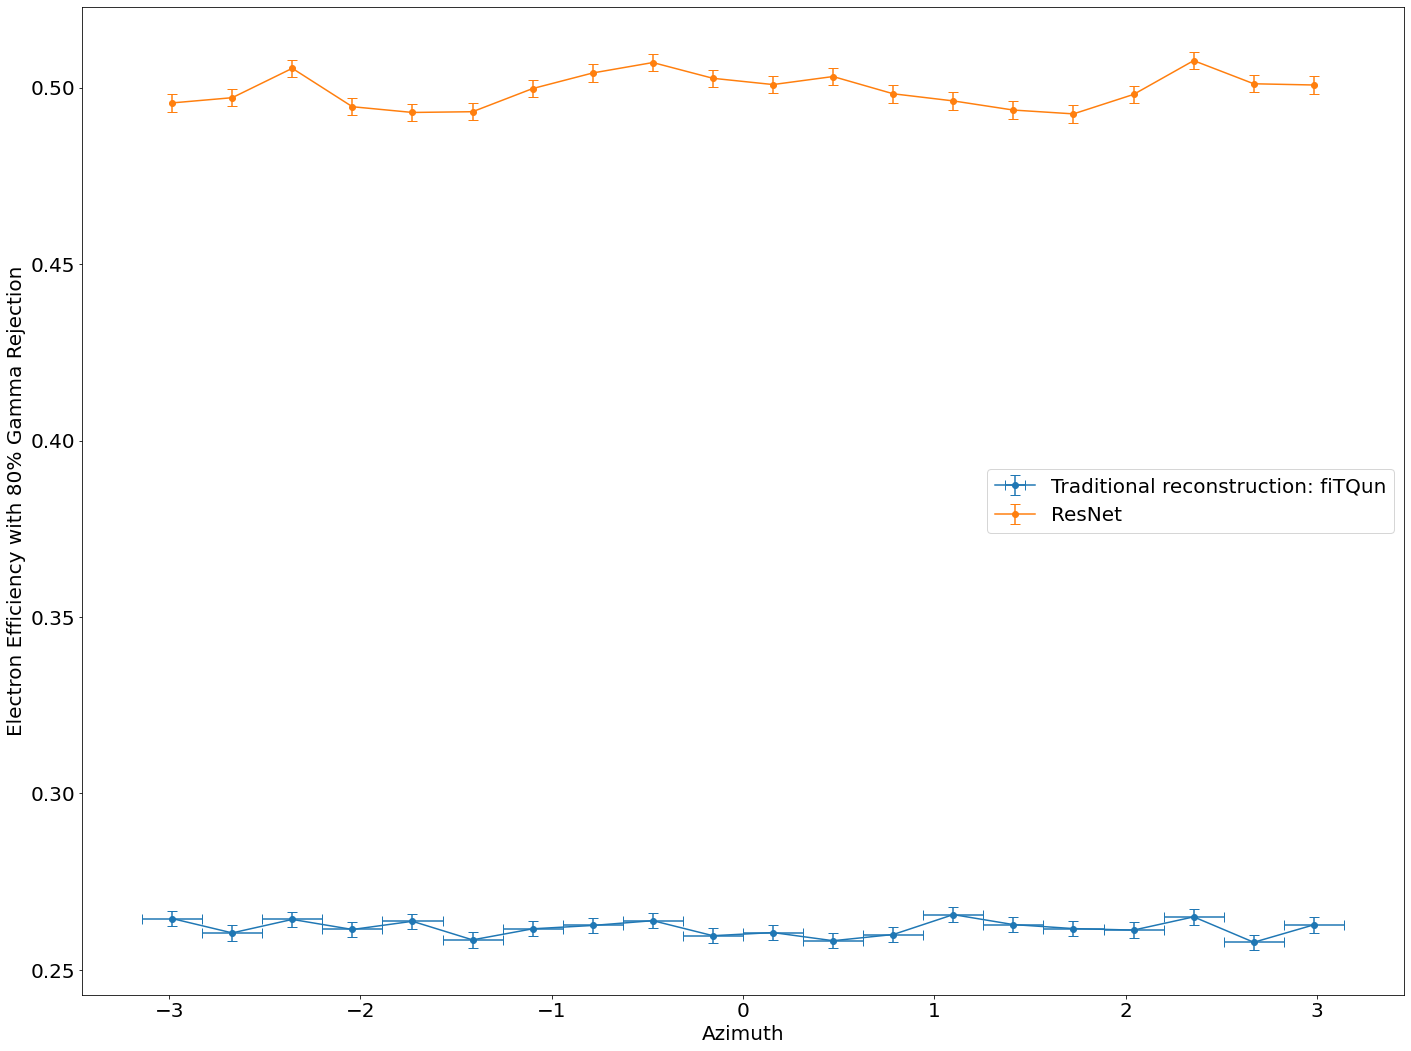

In [43]:
# define the bins for the plot
plot_bin_low = -np.pi
plot_bin_high = np.pi
plot_bin_width = np.pi/10
plot_bin_lows = np.arange(plot_bin_low, plot_bin_high, plot_bin_width)
plot_bin_centres = np.arange(plot_bin_low + plot_bin_width/2, plot_bin_high, plot_bin_width)
plot_bin_halfwidths = np.full_like(plot_bin_centres, plot_bin_width/2)

# for each particle, each bin, find the events in that bin
plot_bin_selections = [
    (azimuth[electrons] > l) & (azimuth[electrons] <= l+plot_bin_width)
    for l in plot_bin_lows
]

# for each particle, for each bin, calculate the efficiency rate and the error bar
# for fiTQun
eg_fq_eff_binned = np.array([np.mean(eg_fq_electron_truepositives[c]) for c in plot_bin_selections])
eg_fq_eff_binned_err = np.sqrt(eg_fq_eff_binned*(1-eg_fq_eff_binned)/np.sum(plot_bin_selections, axis=1))
# for ResNet
eg_rn_eff_binned = [np.array([np.mean(eg_rn_electron_truepositives[i][c]) for c in plot_bin_selections])
                   for i in range(N)]
eg_rn_eff_binned_err = [np.sqrt(eg_rn_eff_binned[i]*(1-eg_rn_eff_binned[i])/np.sum(plot_bin_selections, axis=1))
                       for i in range(N)]

# plot the results
fig, ax = plt.subplots(figsize=(20,15))
ax.errorbar(plot_bin_centres, eg_fq_eff_binned, yerr=eg_fq_eff_binned_err, xerr=plot_bin_halfwidths,
            label='Traditional reconstruction: fiTQun', fmt='-o', capsize=5)

for i in range(N):
    ax.errorbar(plot_bin_centres, eg_rn_eff_binned[i], yerr=eg_rn_eff_binned_err[i],
                label=f'{legend[i]}', fmt='-o', capsize=5,color=colors[i])
    
ax.set_xlabel("Azimuth")
ax.set_ylabel("Electron Efficiency with 80% Gamma Rejection")
ax.legend()
fig.tight_layout()

if SAVE_PLOTS:
    plt.savefig('4_class_results/e_vs_gamma/azimuth.jpg',bbox_inches='tight', dpi=150)

# Electron vs. Pion

### ROC curve for electron signal vs pion rejection

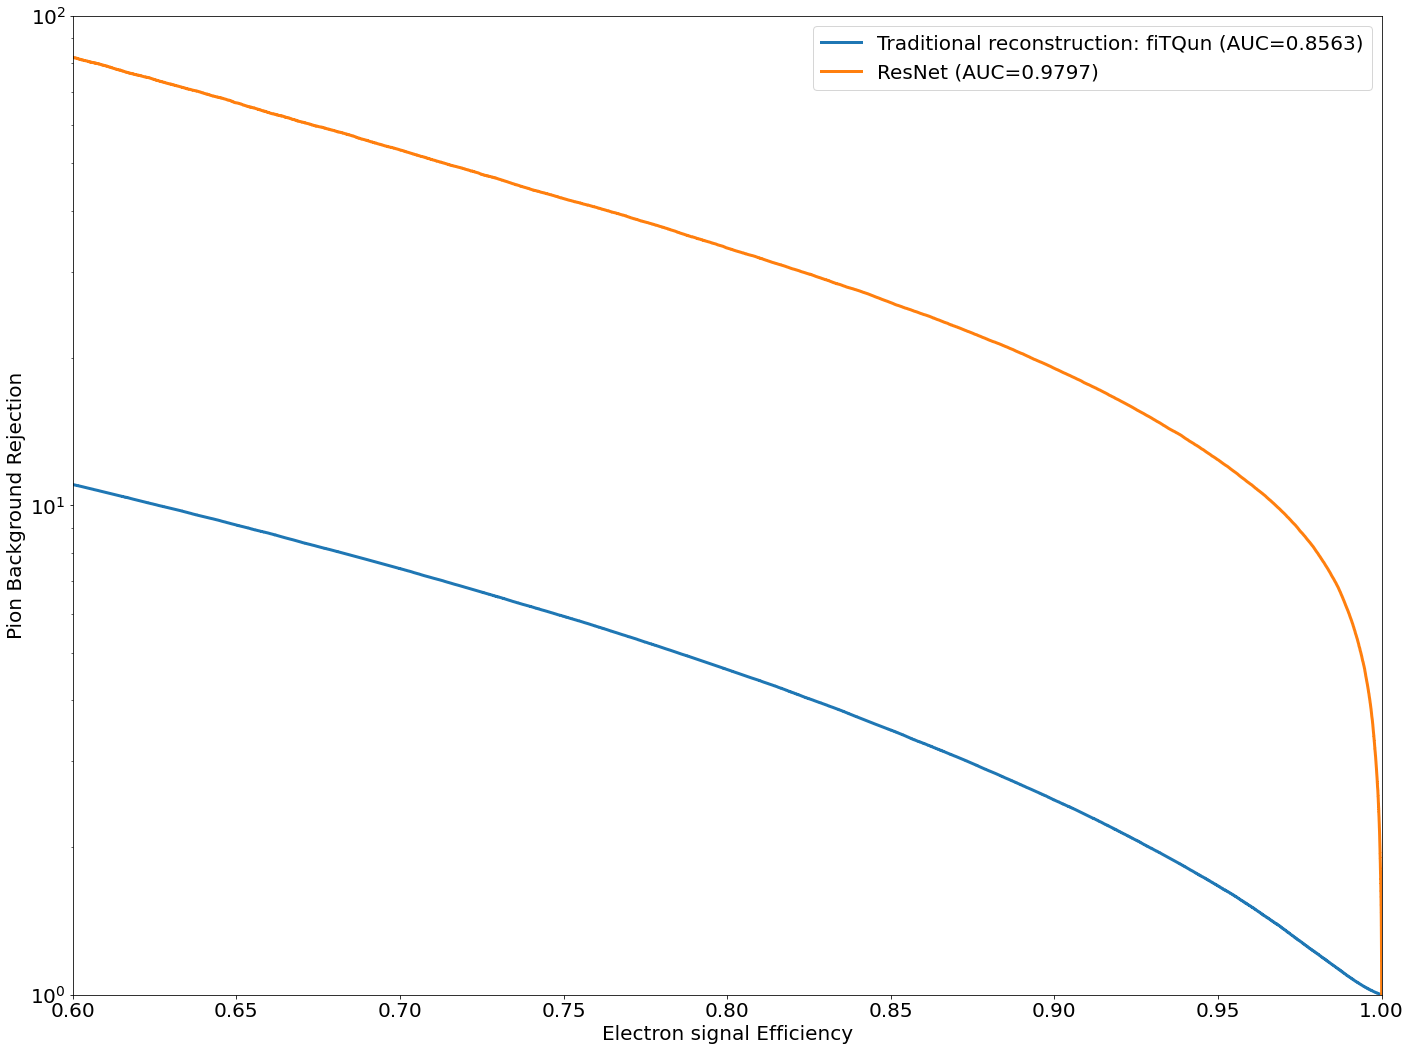

In [44]:
# the electron-like discriminator is the negative log-likelihood difference for fiTQun (es are more mu-like...)
epi0_nll = -(h5_e_nll-h5_pi0_nll)
# Indices for particle types are:
# [0] -> gamma
# [1] -> e
# [2] -> mu
# [3] -> pi0
# Thus the electron-like discriminator for ResNet is:
# (P_e + P_gamma) / (1 - P_mu) = (P_e + P_gamma) / (P_e + P_gamma + P_pi0)
epi0_elike = [(softmaxes[i][:,1] + softmaxes[i][:,0])/(softmaxes[i][:,0] + softmaxes[i][:,1] + softmaxes[i][:,3]) for i in range(N)]

# get the true and false positives
epi0_fq_roc_fpr, epi0_fq_roc_tpr, _ = metrics.roc_curve(h5_labels[epi0_cut]==1, epi0_nll[epi0_cut])

epi0_rn_roc_fpr, epi0_rn_roc_tpr = [],[]
for i in range(N):
    fpr,tpr, _ = metrics.roc_curve(h5_labels[epi0_cut]==1, epi0_elike[i][epi0_cut])
    epi0_rn_roc_fpr.append(fpr)
    epi0_rn_roc_tpr.append(tpr)
    
# get the AUC
epi0_fq_auc = metrics.auc(epi0_fq_roc_fpr, epi0_fq_roc_tpr)
epi0_rn_auc = [metrics.auc(epi0_rn_roc_fpr[i], epi0_rn_roc_tpr[i]) for i in range(N)]

with np.errstate(divide='ignore'):
    epi0_fq_bgr = 1/epi0_fq_roc_fpr
    epi0_rn_bgr = [1/epi0_rn_roc_fpr[i] for i in range(N)]

# plot the results
fig, ax = plt.subplots(figsize=(20,15))
ax.plot(epi0_fq_roc_tpr, epi0_fq_bgr, label=f"Traditional reconstruction: fiTQun (AUC={epi0_fq_auc:.4f})", lw=3)

for i in range(N):
    ax.plot(epi0_rn_roc_tpr[i], epi0_rn_bgr[i], label=f"{legend[i]} (AUC={epi0_rn_auc[i]:.4f})",color=colors[i],lw=3)

ax.set_xlabel("Electron signal Efficiency")
ax.set_ylabel("Pion Background Rejection")
ax.set_yscale('log')
ax.set_ylim((1,100))
ax.set_xlim((0.6,1))
ax.legend()
fig.tight_layout()

if SAVE_PLOTS:
    plt.savefig('4_class_results/e_vs_pi0/roc1.jpg',bbox_inches='tight', dpi=150)

###  for fixed 5% pion mis-ID

### for each 50 MeV bin of reconstructed momentum, calculate the thresholds for fiTQun

In [45]:
# the electron-like discriminator is the negative log-likelihood difference for fiTQun (es are more mu-like...)
epi0_nll = -(h5_e_nll-h5_pi0_nll)

# set up the bins
epi0_bin_low = 0
epi0_bin_high = 1000
epi0_bin_width = 50
epi0_bin_lows = np.arange(epi0_bin_low, epi0_bin_high, epi0_bin_width)

# for each particle type, for each bin, make a boolean array to say whether each event belongs in that bin
epi0_e_bin_selections = [
    (h5_reco_mom_pi0[electrons] > l) & (h5_reco_mom_pi0[electrons] <= l+epi0_bin_width)
    for l in eg_bin_lows
]
epi0_pion_bin_selections = [
    (h5_reco_mom_pi0[pi0s] > l) & (h5_reco_mom_pi0[pi0s] <= l+epi0_bin_width)
    for l in epi0_bin_lows
]

# for each bin, the threshold that gives 5% mis-ID (95% are below the threshold)
epi0_fq_thresholds = [np.quantile(epi0_nll[pi0s][c], 0.95) for c in epi0_pion_bin_selections]

# for each particle type, for each bin, make a, boolean array to say whether each event is below the threshold
# start by filling it full of false
epi0_fq_electron_truepositives = np.zeros_like(epi0_nll[electrons]).astype(bool)
epi0_fq_pion_falsepositives = np.zeros_like(epi0_nll[pi0s]).astype(bool)
# then loop over the bins and set to true for the events in those bins that are over the threshold
for t, c in zip(epi0_fq_thresholds, epi0_e_bin_selections):
    epi0_fq_electron_truepositives[c] = epi0_nll[electrons][c] > t
for t, c in zip(epi0_fq_thresholds, epi0_pion_bin_selections):
    epi0_fq_pion_falsepositives[c] = eg_nll[pi0s][c] > t

### calculate the thresholds for ResNet

In [46]:
# the electron-like discriminator for ResNet is:
epi0_elike = [(softmaxes[i][:,1] + softmaxes[i][:,0])/(softmaxes[i][:,0] + softmaxes[i][:,1] + softmaxes[i][:,3]) for i in range(N)]

# for each bin, the threshold that gives 5% mis-ID (95% are below the threshold)
epi0_rn_thresholds = [
    [np.quantile(epi0_elike[i][pi0s][c], 0.95) for c in epi0_pion_bin_selections] for i in range(N)
]

# for each particle type, for each bin, make a, boolean array to say whether each event is below the threshold
# start by filling it full of false
epi0_rn_electron_truepositives = [np.zeros_like(epi0_elike[i][electrons]).astype(bool) for i in range(N)]
epi0_rn_pion_falsepositives = [np.zeros_like(epi0_elike[i][pi0s]).astype(bool) for i in range(N)]
# then loop over the bins and set to true for the events in those bins that are over the threshold

for i in range(N):
    for t, c in zip(epi0_rn_thresholds[i], epi0_e_bin_selections):
        epi0_rn_electron_truepositives[i][c] = epi0_elike[i][electrons][c] > t
        
for i in range(N):
    for t, c in zip(epi0_rn_thresholds[i], epi0_pion_bin_selections):
        epi0_rn_pion_falsepositives[i][c] = epi0_elike[i][pi0s][c] > t

### Plot against true momentum

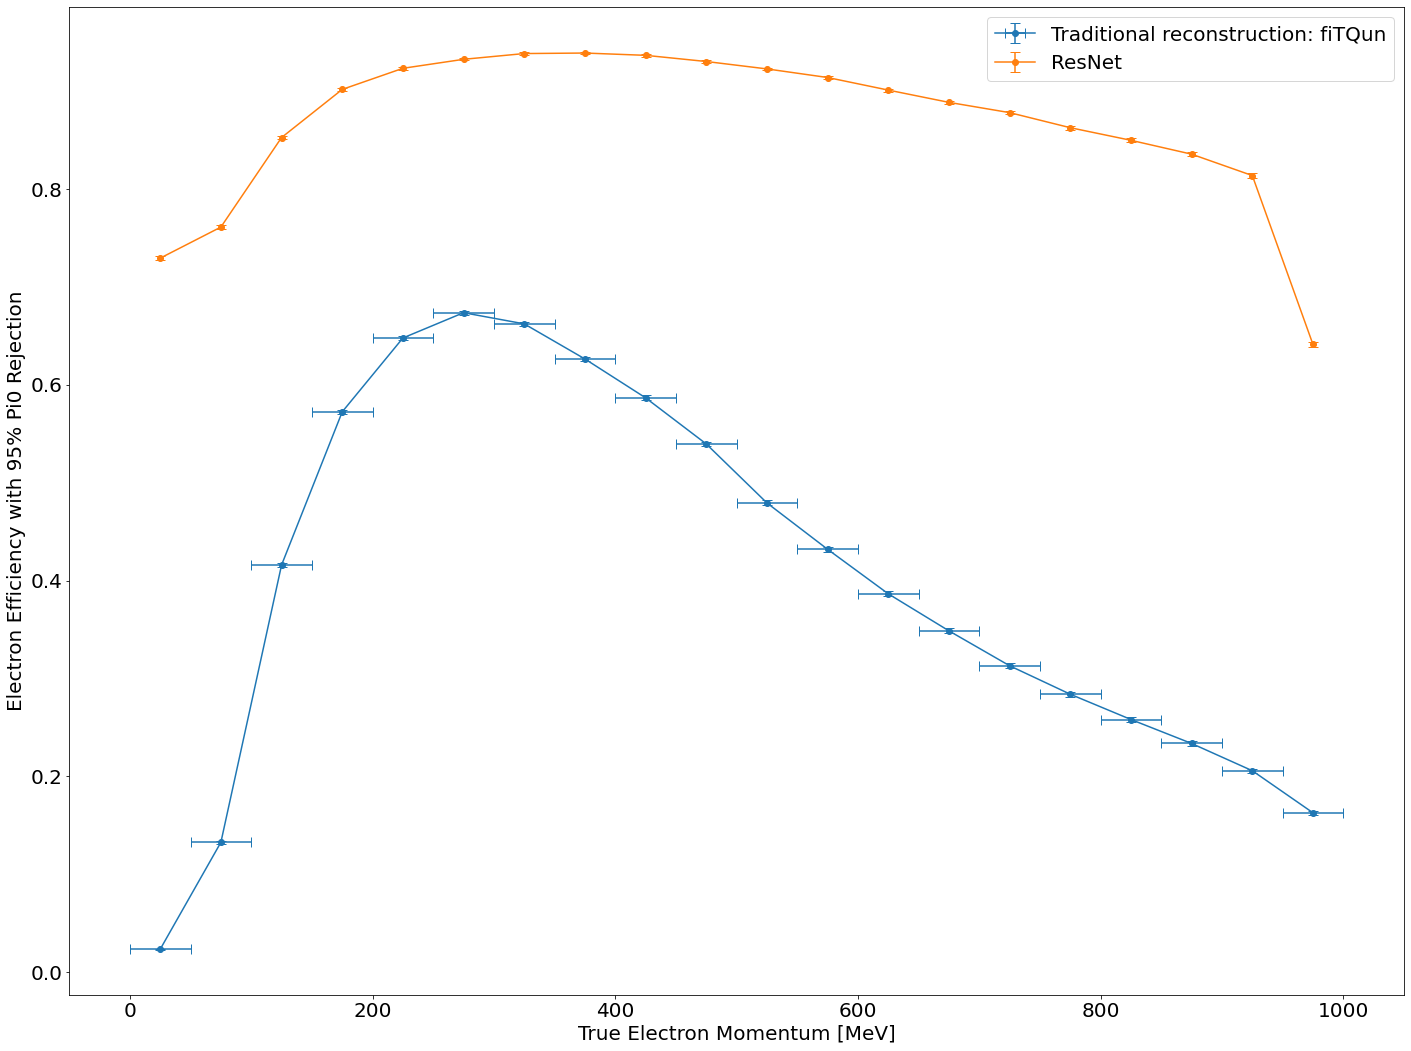

In [47]:
# define the bins for the plot
plot_bin_low = 0
plot_bin_high = 1000
plot_bin_width = 50
plot_bin_lows = np.arange(plot_bin_low, plot_bin_high, plot_bin_width)
plot_bin_centres = np.arange(plot_bin_low + plot_bin_width/2, plot_bin_high, plot_bin_width)
plot_bin_halfwidths = np.full_like(plot_bin_centres, plot_bin_width/2)

# for each particle, each bin, find the events in that bin
plot_bin_selections = [
    (momentum[electrons] > l) & (momentum[electrons] <= l+plot_bin_width)
    for l in plot_bin_lows
]

# for each particle, for each bin, calculate the efficiency rate and the error bar
# for fiTQun
epi0_fq_eff_binned = np.array([np.mean(epi0_fq_electron_truepositives[c]) for c in plot_bin_selections])
epi0_fq_eff_binned_err = np.sqrt(epi0_fq_eff_binned*(1-epi0_fq_eff_binned)/np.sum(plot_bin_selections, axis=1))
# for ResNet
epi0_rn_eff_binned = [np.array([np.mean(epi0_rn_electron_truepositives[i][c]) for c in plot_bin_selections]) 
                    for i in range(N)]
epi0_rn_eff_binned_err = [np.sqrt(epi0_rn_eff_binned[i]*(1-epi0_rn_eff_binned[i])/np.sum(plot_bin_selections, axis=1))
                        for i in range(N)]

# plot the results
fig, ax = plt.subplots(figsize=(20,15))
ax.errorbar(plot_bin_centres, epi0_fq_eff_binned, yerr=epi0_fq_eff_binned_err, xerr=plot_bin_halfwidths,
            label='Traditional reconstruction: fiTQun', fmt='-o', capsize=5)

for i in range(N):
    ax.errorbar(plot_bin_centres, epi0_rn_eff_binned[i], yerr=epi0_rn_eff_binned_err[i],
                label=f'{legend[i]}', fmt='-o', capsize=5,color=colors[i])
    
ax.set_xlabel("True Electron Momentum [MeV]")
ax.set_ylabel("Electron Efficiency with 95% Pi0 Rejection")
ax.legend()
fig.tight_layout()

if SAVE_PLOTS:
    plt.savefig('4_class_results/e_vs_pi0/true_momentum.jpg',bbox_inches='tight', dpi=150)

### Plot against distance to wall, along particle direction

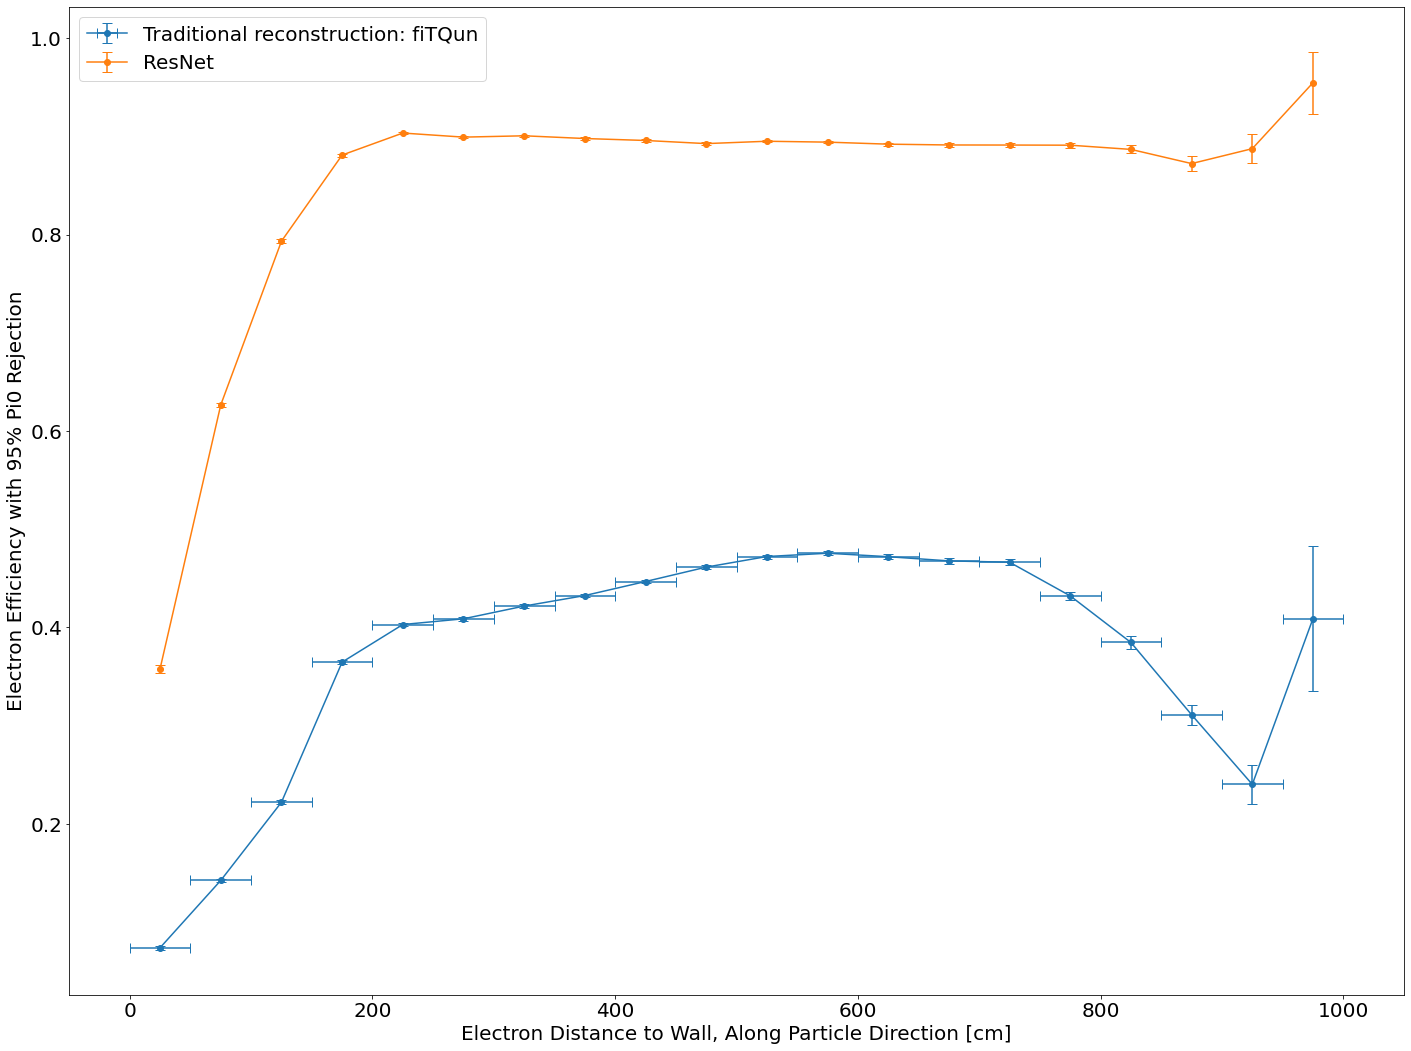

In [48]:
# define the bins for the plot
plot_bin_low = 0
plot_bin_high = 1000
plot_bin_width = 50
plot_bin_lows = np.arange(plot_bin_low, plot_bin_high, plot_bin_width)
plot_bin_centres = np.arange(plot_bin_low + plot_bin_width/2, plot_bin_high, plot_bin_width)
plot_bin_halfwidths = np.full_like(plot_bin_centres, plot_bin_width/2)

# for each particle, each bin, find the events in that bin
plot_bin_selections = [
    (towall[electrons] > l) & (towall[electrons] <= l+plot_bin_width)
    for l in plot_bin_lows
]

# for each particle, for each bin, calculate the efficiency rate and the error bar
# for fiTQun
epi0_fq_eff_binned = np.array([np.mean(epi0_fq_electron_truepositives[c]) for c in plot_bin_selections])
epi0_fq_eff_binned_err = np.sqrt(epi0_fq_eff_binned*(1-epi0_fq_eff_binned)/np.sum(plot_bin_selections, axis=1))
# for ResNet
epi0_rn_eff_binned = [np.array([np.mean(epi0_rn_electron_truepositives[i][c]) for c in plot_bin_selections]) 
                    for i in range(N)]
epi0_rn_eff_binned_err = [np.sqrt(epi0_rn_eff_binned[i]*(1-epi0_rn_eff_binned[i])/np.sum(plot_bin_selections, axis=1))
                        for i in range(N)]

# plot the results
fig, ax = plt.subplots(figsize=(20,15))
ax.errorbar(plot_bin_centres, epi0_fq_eff_binned, yerr=epi0_fq_eff_binned_err, xerr=plot_bin_halfwidths,
            label='Traditional reconstruction: fiTQun', fmt='-o', capsize=5)

for i in range(N):
    ax.errorbar(plot_bin_centres, epi0_rn_eff_binned[i], yerr=epi0_rn_eff_binned_err[i],
                label=f'{legend[i]}', fmt='-o', capsize=5,color=colors[i])
    
ax.set_xlabel("Electron Distance to Wall, Along Particle Direction [cm]")
ax.set_ylabel("Electron Efficiency with 95% Pi0 Rejection")
ax.legend()
fig.tight_layout()

if SAVE_PLOTS:
    plt.savefig('4_class_results/e_vs_pi0/towall.jpg',bbox_inches='tight', dpi=150)

### Plot against dwall

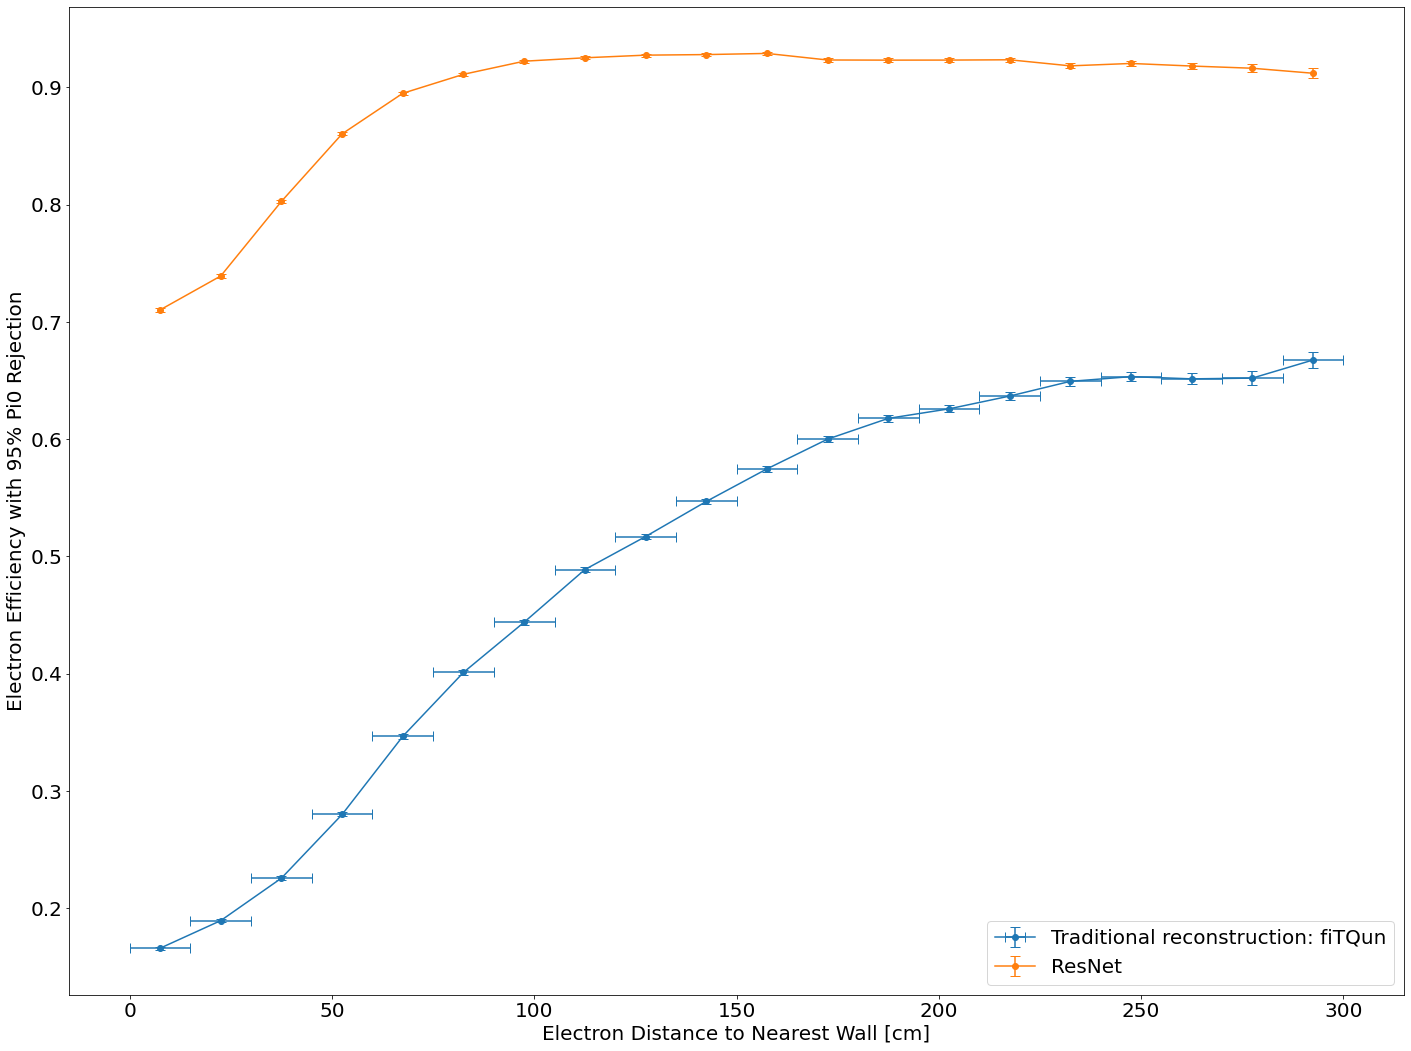

In [49]:
# define the bins for the plot
plot_bin_low = 0
plot_bin_high = 300
plot_bin_width = 15
plot_bin_lows = np.arange(plot_bin_low, plot_bin_high, plot_bin_width)
plot_bin_centres = np.arange(plot_bin_low + plot_bin_width/2, plot_bin_high, plot_bin_width)
plot_bin_halfwidths = np.full_like(plot_bin_centres, plot_bin_width/2)

# for each particle, each bin, find the events in that bin
plot_bin_selections = [
    (dwall[electrons] > l) & (dwall[electrons] <= l+plot_bin_width)
    for l in plot_bin_lows
]

# for each particle, for each bin, calculate the efficiency rate and the error bar
# for fiTQun
epi0_fq_eff_binned = np.array([np.mean(epi0_fq_electron_truepositives[c]) for c in plot_bin_selections])
epi0_fq_eff_binned_err = np.sqrt(epi0_fq_eff_binned*(1-epi0_fq_eff_binned)/np.sum(plot_bin_selections, axis=1))
# for ResNet
epi0_rn_eff_binned = [np.array([np.mean(epi0_rn_electron_truepositives[i][c]) for c in plot_bin_selections]) 
                    for i in range(N)]
epi0_rn_eff_binned_err = [np.sqrt(epi0_rn_eff_binned[i]*(1-epi0_rn_eff_binned[i])/np.sum(plot_bin_selections, axis=1))
                        for i in range(N)]

# plot the results
fig, ax = plt.subplots(figsize=(20,15))
ax.errorbar(plot_bin_centres, epi0_fq_eff_binned, yerr=epi0_fq_eff_binned_err, xerr=plot_bin_halfwidths,
            label='Traditional reconstruction: fiTQun', fmt='-o', capsize=5)

for i in range(N):
    ax.errorbar(plot_bin_centres, epi0_rn_eff_binned[i], yerr=epi0_rn_eff_binned_err[i],
                label=f'{legend[i]}', fmt='-o', capsize=5,color=colors[i])
    
ax.set_xlabel("Electron Distance to Nearest Wall [cm]")
ax.set_ylabel("Electron Efficiency with 95% Pi0 Rejection")
ax.legend()
fig.tight_layout()

if SAVE_PLOTS:
    plt.savefig('4_class_results/e_vs_pi0/dwall.jpg',bbox_inches='tight', dpi=150)

### Plot against zenith

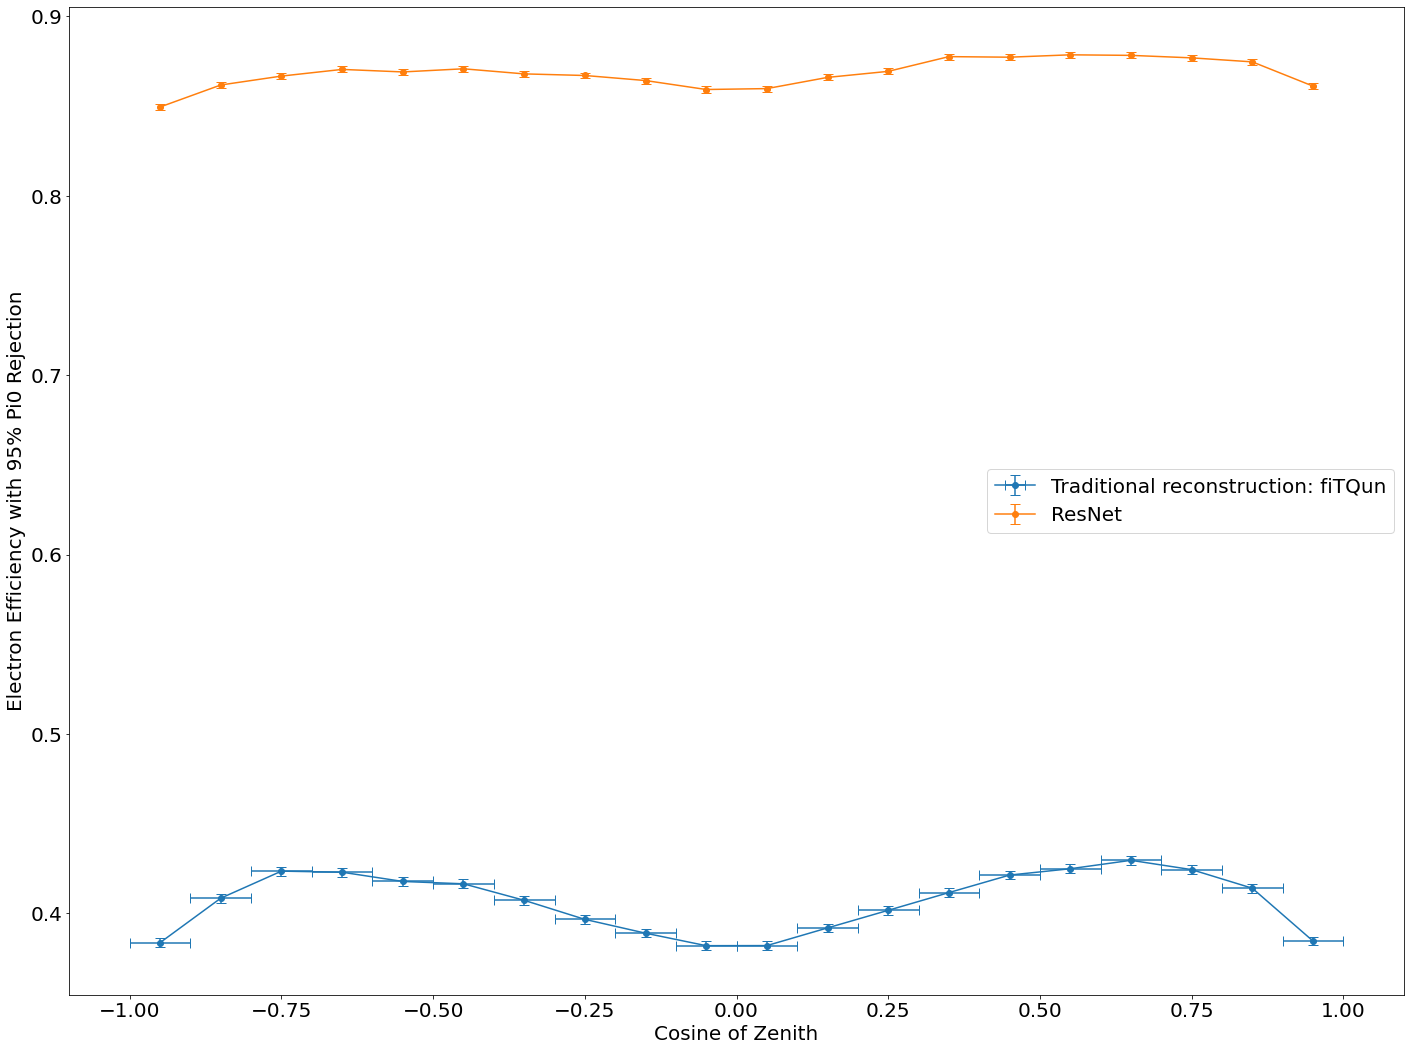

In [50]:
# define the bins for the plot
plot_bin_low = -1
plot_bin_high = 1
plot_bin_width = 1/10
plot_bin_lows = np.arange(plot_bin_low, plot_bin_high, plot_bin_width)
plot_bin_centres = np.arange(plot_bin_low + plot_bin_width/2, plot_bin_high, plot_bin_width)
plot_bin_halfwidths = np.full_like(plot_bin_centres, plot_bin_width/2)

# for each particle, each bin, find the events in that bin
plot_bin_selections = [
    (zenith[electrons] > l) & (zenith[electrons] <= l+plot_bin_width)
    for l in plot_bin_lows
]

# for each particle, for each bin, calculate the efficiency rate and the error bar
# for fiTQun
epi0_fq_eff_binned = np.array([np.mean(epi0_fq_electron_truepositives[c]) for c in plot_bin_selections])
epi0_fq_eff_binned_err = np.sqrt(epi0_fq_eff_binned*(1-epi0_fq_eff_binned)/np.sum(plot_bin_selections, axis=1))
# for ResNet
epi0_rn_eff_binned = [np.array([np.mean(epi0_rn_electron_truepositives[i][c]) for c in plot_bin_selections]) 
                    for i in range(N)]
epi0_rn_eff_binned_err = [np.sqrt(epi0_rn_eff_binned[i]*(1-epi0_rn_eff_binned[i])/np.sum(plot_bin_selections, axis=1))
                        for i in range(N)]

# plot the results
fig, ax = plt.subplots(figsize=(20,15))
ax.errorbar(plot_bin_centres, epi0_fq_eff_binned, yerr=epi0_fq_eff_binned_err, xerr=plot_bin_halfwidths,
            label='Traditional reconstruction: fiTQun', fmt='-o', capsize=5)

for i in range(N):
    ax.errorbar(plot_bin_centres, epi0_rn_eff_binned[i], yerr=epi0_rn_eff_binned_err[i],
                label=f'{legend[i]}', fmt='-o', capsize=5,color=colors[i])
    
ax.set_xlabel("Cosine of Zenith")
ax.set_ylabel("Electron Efficiency with 95% Pi0 Rejection")
ax.legend()
fig.tight_layout()

if SAVE_PLOTS:
    plt.savefig('4_class_results/e_vs_pi0/zenith.jpg',bbox_inches='tight', dpi=150)

### Plot against Azimuth

In [51]:
azimuth = h5_angles[:,1]

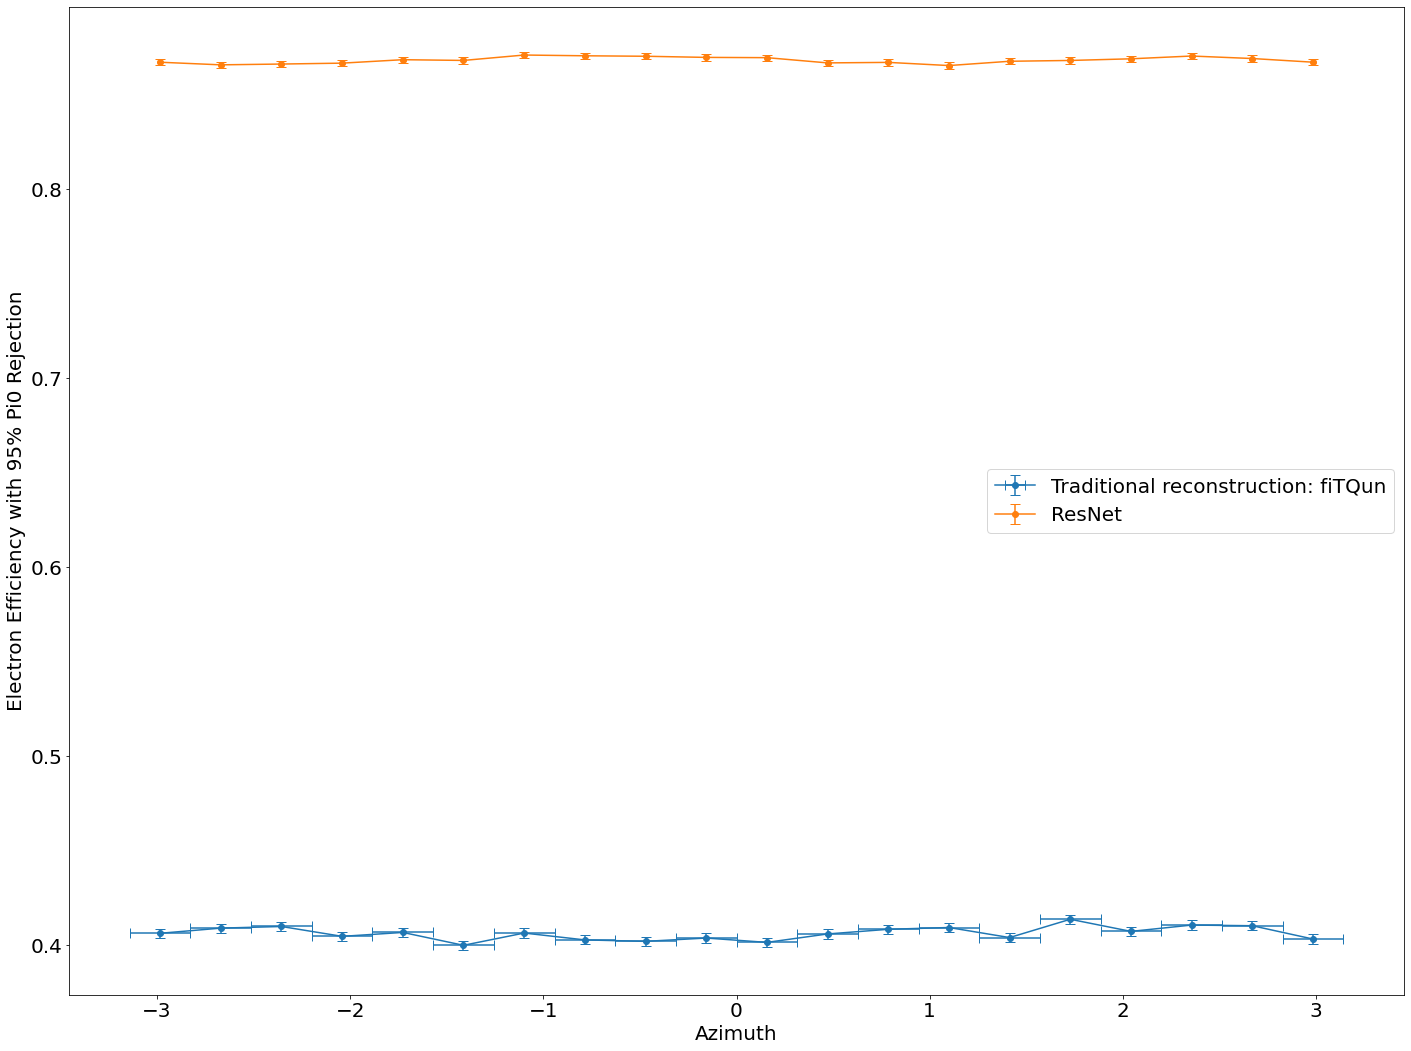

In [52]:
# define the bins for the plot
plot_bin_low = -np.pi
plot_bin_high = np.pi
plot_bin_width = np.pi/10
plot_bin_lows = np.arange(plot_bin_low, plot_bin_high, plot_bin_width)
plot_bin_centres = np.arange(plot_bin_low + plot_bin_width/2, plot_bin_high, plot_bin_width)
plot_bin_halfwidths = np.full_like(plot_bin_centres, plot_bin_width/2)

# for each particle, each bin, find the events in that bin
plot_bin_selections = [
    (azimuth[electrons] > l) & (azimuth[electrons] <= l+plot_bin_width)
    for l in plot_bin_lows
]

# for each particle, for each bin, calculate the efficiency rate and the error bar
# for fiTQun
epi0_fq_eff_binned = np.array([np.mean(epi0_fq_electron_truepositives[c]) for c in plot_bin_selections])
epi0_fq_eff_binned_err = np.sqrt(epi0_fq_eff_binned*(1-epi0_fq_eff_binned)/np.sum(plot_bin_selections, axis=1))
# for ResNet
epi0_rn_eff_binned = [np.array([np.mean(epi0_rn_electron_truepositives[i][c]) for c in plot_bin_selections]) 
                    for i in range(N)]
epi0_rn_eff_binned_err = [np.sqrt(epi0_rn_eff_binned[i]*(1-epi0_rn_eff_binned[i])/np.sum(plot_bin_selections, axis=1))
                        for i in range(N)]

# plot the results
fig, ax = plt.subplots(figsize=(20,15))
ax.errorbar(plot_bin_centres, epi0_fq_eff_binned, yerr=epi0_fq_eff_binned_err, xerr=plot_bin_halfwidths,
            label='Traditional reconstruction: fiTQun', fmt='-o', capsize=5)

for i in range(N):
    ax.errorbar(plot_bin_centres, epi0_rn_eff_binned[i], yerr=epi0_rn_eff_binned_err[i],
                label=f'{legend[i]}', fmt='-o', capsize=5,color=colors[i])
    
ax.set_xlabel("Azimuth")
ax.set_ylabel("Electron Efficiency with 95% Pi0 Rejection")
ax.legend()
fig.tight_layout()

if SAVE_PLOTS:
    plt.savefig('4_class_results/e_vs_pi0/azimuth.jpg',bbox_inches='tight', dpi=150)